# Impact of Governmental Investment Policies in Science and Technology through the Synthetic Diff in Diff

<table align="inner">
  <td>
    <a href="https://github.com/rod53/BrScienceSDID/blob/main/IGERDBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>

## 1 SETUP
Check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20. Import the libraries for the analysis. Ensure MatplotLib plots figures inline and prepare a function to save the figures. Set where to save the figures.

In [47]:
import sys
assert sys.version_info >= (3, 5) # Python ≥3.5 is required
import sklearn
assert sklearn.__version__ >= "0.20"# Scikit-Learn ≥0.20 is required
import numpy as np
import os
import tarfile
import urllib.request
import pandas as pd
import pycountry
import pycountry_convert as pc
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from toolz import curry, partial
import seaborn as sns
from matplotlib import pyplot as plt
import cvxpy as cp

# To ignore some boring warnings
import warnings
warnings.filterwarnings('ignore')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from matplotlib import style
style.use("ggplot")
pd.set_option('display.max_columns', 60)

## 2 GET THE DATA
The datasets used in this study were collected from four different databases, which are described in the following sections. 

_(Note to Prof. Brei: so far have coded only two of the four databases. The other two are SCImago Database (from Elsevier/Scopus) and the World Intelectual Property Organization (WIPO). Both databases extraction are in the process of being coded.)_

### 2.1 Sistema Integrado de Planejamento e Orçamento (SIOP)
Data collected from Sistema Integrado de Planejamento e Orçamento (SIOP) from the Brazilian Ministry of Economy (ME) and the Brazilian Ministry of Science, Technology, Innovation and Communication (MCTIC). The SIOP is the main tool for the formulation and monitoring of the Brazilian public budget. The data are available in the SIOP website (https://siop.mec.gov.br/). The data were collected from 2000 to 2020.

In [27]:
# #Import data from github for each dataset in SIOP
# CAPESurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/SIOP/CAPES.csv"
# CAPESdf = pd.read_csv(CAPESurl, sep=";", encoding="utf-8")

# CNPQurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/SIOP/CNPq.csv"
# CNPQdf = pd.read_csv(CNPQurl, sep=";", encoding="utf-8")

# FNDCTurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/SIOP/FNDCT.csv"
# FNDCTdf = pd.read_csv(FNDCTurl, sep=";", encoding="utf-8")
# # Leave only the columns of interest
# CAPESdf = CAPESdf[['Ano', 'Função', 'Projeto de Lei', 'Dotação Inicial', 'Dotação Atual', 'Empenhado', 'Liquidado', 'Pago']]
# # Eliminate the rows with the total of the 
# CAPESdf = CAPESdf[CAPESdf['Ano'] != 'Total']
# # # Replace "." for "," in whole dataframe
# # CAPESdf = CAPESdf.replace('.', '', regex=True)

# # Sum total per year
# CAPESdf = CAPESdf.groupby(['Ano']).sum()

# # Convert the columns to numeric
# CAPESdf['Projeto de Lei'] = pd.to_numeric(CAPESdf['Projeto de Lei'], errors='coerce')
# CAPESdf['Dotação Inicial'] = pd.to_numeric(CAPESdf['Dotação Inicial'], errors='coerce')
# CAPESdf['Dotação Atual'] = pd.to_numeric(CAPESdf['Dotação Atual'], errors='coerce')
# CAPESdf['Empenhado'] = pd.to_numeric(CAPESdf['Empenhado'], errors='coerce')
# CAPESdf['Liquidado'] = pd.to_numeric(CAPESdf['Liquidado'], errors='coerce')
# CAPESdf['Pago'] = pd.to_numeric(CAPESdf['Pago'], errors='coerce')



### 2.2 UNESCO Institute of Statistics (UIS)
Free and open access to global demographic, socio-economical data, used as covariate in the SCM ans SDID. Available in http://data.uis.unesco.org/.

In [28]:
#Import data from github for each dataset in UIS
APOPurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/APOP.csv"
APOPdf = pd.read_csv(APOPurl, sep=";", encoding="latin-1")
GDPurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GDP.csv"
GDPdf = pd.read_csv(GDPurl, sep=";", encoding="latin-1")
GDPPCurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GDPPC.csv"
GDPPCdf = pd.read_csv(GDPPCurl, sep=";", encoding="latin-1")
GETEurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GETE.csv"
GETEdf = pd.read_csv(GETEurl, sep=";", encoding="latin-1")
GERDurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GERD.csv"
GERDdf = pd.read_csv(GERDurl, sep=";", encoding="latin-1")
RPMIurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/RPMI.csv"
RPMIdf = pd.read_csv(RPMIurl, sep=";", encoding="latin-1")

# The datasets include other variables on the same file, this code aims to leave only the desired rows
APOPdf = APOPdf[APOPdf['Indicator'] == "Population aged 25-64 years (thousands) "]
GDPdf = GDPdf[GDPdf['Indicator'] == "GDP, PPP (constant 2011 international $)"]
GDPPCdf = GDPPCdf[GDPPCdf['Indicator'] == "GDP per capita, PPP (constant 2011 international $)"]
GETEdf = GETEdf[GETEdf['Indicator'] == "Government expenditure on tertiary education as a percentage of GDP (%)"]
GERDdf = GERDdf[GERDdf['Indicator'] == "GERD as a percentage of GDP"]
RPMIdf = RPMIdf[RPMIdf['Indicator'] == "Researchers per million inhabitants (FTE)"]

# Sort by Code and Year
APOPdf.sort_values(by=['Code', 'Year'], inplace=True)
GDPdf.sort_values(by=['Code', 'Year'], inplace=True)
GDPPCdf.sort_values(by=['Code', 'Year'], inplace=True)
GETEdf.sort_values(by=['Code', 'Year'], inplace=True)
GERDdf.sort_values(by=['Code', 'Year'], inplace=True)
RPMIdf.sort_values(by=['Code', 'Year'], inplace=True)

# Leave only the columns of interest
APOPdf = APOPdf[['Code', 'Year', 'Value']]
GDPdf = GDPdf[['Code', 'Year', 'Value']]
GDPPCdf = GDPPCdf[['Code', 'Year', 'Value']]
GETEdf = GETEdf[['Code', 'Year', 'Value']]
GERDdf = GERDdf[['Code', 'Year', 'Value']]
RPMIdf = RPMIdf[['Code', 'Year', 'Value']]

# Rename the columns with name of the indicator
APOPdf.rename(columns={'Value': 'APOP'}, inplace=True)
GDPdf.rename(columns={'Value': 'GDP'}, inplace=True)
GDPPCdf.rename(columns={'Value': 'GDPPC'}, inplace=True)
GETEdf.rename(columns={'Value': 'GETE'}, inplace=True)
GERDdf.rename(columns={'Value': 'GERD'}, inplace=True)
RPMIdf.rename(columns={'Value': 'RPMI'}, inplace=True)

# sum how many countries appear 22 times in each dataframe
print((APOPdf['Code'].value_counts() == 22).value_counts())
print((GDPdf['Code'].value_counts() == 22).value_counts())
print((GDPPCdf['Code'].value_counts() == 22).value_counts())
print((GETEdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data
print((GERDdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data
print((RPMIdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data

True     213
False     17
Name: Code, dtype: int64
True     172
False     21
Name: Code, dtype: int64
True     172
False     21
Name: Code, dtype: int64
False    177
True       7
Name: Code, dtype: int64
False    180
True       4
Name: Code, dtype: int64
False    173
True       2
Name: Code, dtype: int64


### 2.3 InCites - Clarivates (IC)
InCites is a paid-access platform from Clarivates, the same group as the Web of Science (WoS), that provides access to multiple databases of reference and citation data from academic journals, conference proceedings, and other documents in various academic disciplines. Available on https://incites.clarivate.com/.

In [29]:
#Import data from github for each dataset in IC
IC2000url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2000IncitesLocations.csv"
IC2000df = pd.read_csv(IC2000url, sep=";", encoding="latin-1")
IC2001url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2001IncitesLocations.csv"
IC2001df = pd.read_csv(IC2001url, sep=";", encoding="latin-1")
IC2002url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2002IncitesLocations.csv"
IC2002df = pd.read_csv(IC2002url, sep=",", encoding="latin-1")
IC2003url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2003IncitesLocations.csv"
IC2003df = pd.read_csv(IC2003url, sep=",", encoding="latin-1")
IC2004url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2004IncitesLocations.csv"
IC2004df = pd.read_csv(IC2004url, sep=",", encoding="latin-1")
IC2005url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2005IncitesLocations.csv"
IC2005df = pd.read_csv(IC2005url, sep=",", encoding="latin-1")
IC2006url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2006IncitesLocations.csv"
IC2006df = pd.read_csv(IC2006url, sep=",", encoding="latin-1")
IC2007url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2007IncitesLocations.csv"
IC2007df = pd.read_csv(IC2007url, sep=",", encoding="latin-1")
IC2008url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2008IncitesLocations.csv"
IC2008df = pd.read_csv(IC2008url, sep=",", encoding="latin-1")
IC2009url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2009IncitesLocations.csv"
IC2009df = pd.read_csv(IC2009url, sep=",", encoding="latin-1")
IC2010url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2010IncitesLocations.csv"
IC2010df = pd.read_csv(IC2010url, sep=",", encoding="latin-1")
IC2011url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2011IncitesLocations.csv"
IC2011df = pd.read_csv(IC2011url, sep=",", encoding="latin-1")
IC2012url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2012IncitesLocations.csv"
IC2012df = pd.read_csv(IC2012url, sep=",", encoding="latin-1")
IC2013url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2013IncitesLocations.csv"
IC2013df = pd.read_csv(IC2013url, sep=",", encoding="latin-1")
IC2014url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2014IncitesLocations.csv"
IC2014df = pd.read_csv(IC2014url, sep=",", encoding="latin-1")
IC2015url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2015IncitesLocations.csv"
IC2015df = pd.read_csv(IC2015url, sep=",", encoding="latin-1")
IC2016url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2016IncitesLocations.csv"
IC2016df = pd.read_csv(IC2016url, sep=",", encoding="latin-1")
IC2017url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2017IncitesLocations.csv"
IC2017df = pd.read_csv(IC2017url, sep=",", encoding="latin-1")
IC2018url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2018IncitesLocations.csv"
IC2018df = pd.read_csv(IC2018url, sep=",", encoding="latin-1")
IC2019url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2019IncitesLocations.csv"
IC2019df = pd.read_csv(IC2019url, sep=",", encoding="latin-1")
IC2020url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2020IncitesLocations.csv"
IC2020df = pd.read_csv(IC2020url, sep=",", encoding="latin-1")
IC2021url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2021IncitesLocations.csv"
IC2021df = pd.read_csv(IC2021url, sep=",", encoding="latin-1")

# Add a new line in the beginning of each dataset with the year
IC2000df.insert(0, 'Year', '2000')
IC2001df.insert(0, 'Year', '2001')
IC2002df.insert(0, 'Year', '2002')
IC2003df.insert(0, 'Year', '2003')
IC2004df.insert(0, 'Year', '2004')
IC2005df.insert(0, 'Year', '2005')
IC2006df.insert(0, 'Year', '2006')
IC2007df.insert(0, 'Year', '2007')
IC2008df.insert(0, 'Year', '2008')
IC2009df.insert(0, 'Year', '2009')
IC2010df.insert(0, 'Year', '2010')
IC2011df.insert(0, 'Year', '2011')
IC2012df.insert(0, 'Year', '2012')
IC2013df.insert(0, 'Year', '2013')
IC2014df.insert(0, 'Year', '2014')
IC2015df.insert(0, 'Year', '2015')
IC2016df.insert(0, 'Year', '2016')
IC2017df.insert(0, 'Year', '2017')
IC2018df.insert(0, 'Year', '2018')
IC2019df.insert(0, 'Year', '2019')
IC2020df.insert(0, 'Year', '2020')
IC2021df.insert(0, 'Year', '2021')

# Rename the second column to "Name"
IC2000df.rename(columns={IC2000df.columns[1]: "Name"}, inplace=True)
IC2001df.rename(columns={IC2001df.columns[1]: "Name"}, inplace=True)
IC2002df.rename(columns={IC2002df.columns[1]: "Name"}, inplace=True)
IC2003df.rename(columns={IC2003df.columns[1]: "Name"}, inplace=True)
IC2004df.rename(columns={IC2004df.columns[1]: "Name"}, inplace=True)
IC2005df.rename(columns={IC2005df.columns[1]: "Name"}, inplace=True)
IC2006df.rename(columns={IC2006df.columns[1]: "Name"}, inplace=True)
IC2007df.rename(columns={IC2007df.columns[1]: "Name"}, inplace=True)
IC2008df.rename(columns={IC2008df.columns[1]: "Name"}, inplace=True)
IC2009df.rename(columns={IC2009df.columns[1]: "Name"}, inplace=True)
IC2010df.rename(columns={IC2010df.columns[1]: "Name"}, inplace=True)
IC2011df.rename(columns={IC2011df.columns[1]: "Name"}, inplace=True)
IC2012df.rename(columns={IC2012df.columns[1]: "Name"}, inplace=True)
IC2013df.rename(columns={IC2013df.columns[1]: "Name"}, inplace=True)
IC2014df.rename(columns={IC2014df.columns[1]: "Name"}, inplace=True)
IC2015df.rename(columns={IC2015df.columns[1]: "Name"}, inplace=True)
IC2016df.rename(columns={IC2016df.columns[1]: "Name"}, inplace=True)
IC2017df.rename(columns={IC2017df.columns[1]: "Name"}, inplace=True)
IC2018df.rename(columns={IC2018df.columns[1]: "Name"}, inplace=True)
IC2019df.rename(columns={IC2019df.columns[1]: "Name"}, inplace=True)
IC2020df.rename(columns={IC2020df.columns[1]: "Name"}, inplace=True)
IC2021df.rename(columns={IC2021df.columns[1]: "Name"}, inplace=True)

# Import csv from https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/CountryCode.csv
CODEurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/CountryCode.csv"
CODEdf = pd.read_csv(CODEurl, sep=";", encoding="latin-1")
CODEdf.head()

# Create a new column with the country code
IC2000df['Code'] = IC2000df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2001df['Code'] = IC2001df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2002df['Code'] = IC2002df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2003df['Code'] = IC2003df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2004df['Code'] = IC2004df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2005df['Code'] = IC2005df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2006df['Code'] = IC2006df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2007df['Code'] = IC2007df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2008df['Code'] = IC2008df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2009df['Code'] = IC2009df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2010df['Code'] = IC2010df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2011df['Code'] = IC2011df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2012df['Code'] = IC2012df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2013df['Code'] = IC2013df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2014df['Code'] = IC2014df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2015df['Code'] = IC2015df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2016df['Code'] = IC2016df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2017df['Code'] = IC2017df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2018df['Code'] = IC2018df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2019df['Code'] = IC2019df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2020df['Code'] = IC2020df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2021df['Code'] = IC2021df['Name'].map(CODEdf.set_index('Name')['Code'])
# Merge all dataframes
ICdf = pd.concat([IC2000df, IC2001df, IC2002df, IC2003df, IC2004df, IC2005df, IC2006df, IC2007df, IC2008df, IC2009df, IC2010df, IC2011df, IC2012df, IC2013df, IC2014df, IC2015df, IC2016df, IC2017df, IC2018df, IC2019df, IC2020df, IC2021df], ignore_index=True)
ICdf['Year']=ICdf['Year'].astype(int) # Convert year to integer, to be able to merge to other tables

# Convert Web of Science to numeric 
ICdf['Web of Science Documents'] = pd.to_numeric(ICdf['Web of Science Documents'], errors='coerce')

ICdf.head()

,Year,Name,Web of Science Documents,Times Cited,Rank,% Docs Cited,Category Normalized Citation Impact,International Collaborations,All Open Access Documents,% First Author (2008-2022),% Global Baseline (Docs),% Documents in Top 1%,% International Collaborations,Gold Documents,% Last Author (2008-2022),...,% Documents in Q1 Journals,% Gold - Hybrid Documents,% Documents in Q2 Journals,% Free to Read Documents,% Documents in Q3 Journals,% Green Submitted Documents,% Documents in Q4 Journals,% Green Accepted Documents,% Green Published Documents,Documents in Top 1%,Documents in Top 10%,% Green Only Documents,Hot Papers,% Non-Open Access Documents,Code
0,2000,Global Baseline,1348891.0,35800053.0,NaN,65.84,0.986064,147694.0,152555.0,NaN,100.000000,1.20,10.95,8126.0,NaN,...,47.37,0.73,22.53,5.92,16.02,2.91,14.08,0.32,3.28,16204.0,132442.0,4.06,0.0,88.69,NaN
1,2000,Baseline for All Items,1168409.0,35591771.0,NaN,73.65,1.050718,147694.0,148532.0,NaN,NaN,1.29,12.64,7844.0,NaN,...,49.18,0.84,23.17,6.58,15.98,3.32,11.67,0.36,3.73,15048.0,125778.0,4.62,0.0,87.29,NaN
2,2000,USA,435823.0,17265962.0,1.0,70.54,1.353955,67767.0,60026.0,0.0,32.309727,1.91,15.55,1757.0,0.0,...,60.62,1.24,20.00,6.83,12.43,3.46,6.95,0.43,4.30,8319.0,61385.0,5.30,0.0,86.23,USA
3,2000,UNITED KINGDOM,116683.0,4239808.0,2.0,72.80,1.227118,28657.0,18903.0,0.0,8.650291,1.63,24.56,410.0,0.0,...,53.90,0.70,25.43,9.59,13.15,3.60,7.52,1.00,5.94,1898.0,14668.0,5.55,0.0,83.80,GBR
4,2000,ENGLAND,99285.0,3682421.0,3.0,72.97,1.242332,24519.0,16312.0,0.0,7.360491,1.66,24.70,349.0,0.0,...,54.31,0.70,25.27,9.71,12.96,3.71,7.46,0.97,6.10,1648.0,12727.0,5.67,0.0,83.57,NaN


## 3 CONSOLIDATE DATA
This section aims to consolidate the data from the different sources, in order to create a single dataset with all the information needed for the analysis.

In [30]:
# Import ID to be used to find the Codes for IC data
IDurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/ID.csv"
IDdf = pd.read_csv(IDurl, sep=";", encoding="latin-1")
#rename the first column to "Name"
IDdf.rename(columns={IDdf.columns[0]: "Name"}, inplace=True)
# Leave only one name for each country
IDdf.drop(IDdf.columns[[1,2,3]], axis=1, inplace=True)
IDdf.head()

# Create a list of countries to be used in the analysis
DB = IDdf.copy()
DB['Year'] = [2000]*213
for i in range(2001, 2022):
    DBappend = IDdf.copy()
    DBappend['Year'] = [i]*213
    DB = DB.append(DBappend, ignore_index=True)

#Join all datasets in one
df = pd.merge(DB, APOPdf, on=['Code', 'Year'], how='outer', suffixes= ('', '_y'))
df = pd.merge(df, GDPdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GDPPCdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GETEdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GERDdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, RPMIdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, ICdf, on=['Code', 'Year'], how='outer')

#Sort by Code and Year
df.sort_values(by=['Code', 'Year'], inplace=True)

# Rename column "Name_x" to "Country"
df.rename(columns={'Name_x': 'Country'}, inplace=True)

# Drop coloumn "Name_y"
df.drop('Name_y', axis=1, inplace=True)

# Drop coloumn "Location Type"
df.drop('Location Type', axis=1, inplace=True)

# Drop columns which the label start with "%"
df = df.loc[:, ~df.columns.str.startswith('%')]

#Drop rows with missing values in Country
df.dropna(subset=['Country'], inplace=True)



## 4 FIRST LOOK AT THE 
This section aims to get a first look at the data, in order to understand the structure of the dataset and the variables that will be used in the analysis.

In [31]:
# Count how many countries show up in df
print(df['Country'].nunique())

# General information about the dataset
df.info()

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100

213
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4686 entries, 9 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4686 non-null   object 
 1   Code                                 4686 non-null   object 
 2   Region                               4642 non-null   object 
 3   Income Group                         4642 non-null   object 
 4   Year                                 4686 non-null   int64  
 5   APOP                                 4510 non-null   float64
 6   GDP                                  4168 non-null   float64
 7   GDPPC                                4168 non-null   float64
 8   GETE                                 1815 non-null   float64
 9   GERD                                 1891 non-null   float64
 10  RPMI                                 1492 non-null   float64
 11  Web of Science Documents  

Country                                 0.000000
Code                                    0.000000
Region                                  0.938967
Income Group                            0.938967
Year                                    0.000000
APOP                                    3.755869
GDP                                    11.054204
GDPPC                                  11.054204
GETE                                   61.267606
GERD                                   59.645753
RPMI                                   68.160478
Web of Science Documents                8.557405
Times Cited                             8.557405
Rank                                    8.557405
Category Normalized Citation Impact     8.557405
International Collaborations            8.557405
All Open Access Documents               8.557405
Gold Documents                          8.557405
Citation Impact                         8.557405
Gold - Hybrid Documents                 8.557405
Average Percentile  

## 5 CLEANING MISSING DATA

This section aims to clean the data, in order to remove the missing values.

The approach used is to remove the missing values was the interpolation of the missing values with the mean of the values of the adjacent years. The interpolation with the mean of the values of the adjacent years is a good approximation of the value of the year in question.

_(Note to Prof. Brei: Regarding the outliers, I will not remove them, because they may contribute to the analysis. Both SCM and SDID are tolerant to atypical values.)_

In [32]:
# Interpolate missing values for each Country, using values from previous and next years
df['APOP'] = df.groupby('Country')['APOP'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['GDP'] = df.groupby('Country')['GDP'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['GDPPC'] = df.groupby('Country')['GDPPC'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['GETE'] = df.groupby('Country')['GETE'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['GERD'] = df.groupby('Country')['GERD'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['RPMI'] = df.groupby('Country')['RPMI'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Web of Science Documents'] = df.groupby('Country')['Web of Science Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Times Cited'] = df.groupby('Country')['Times Cited'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Rank'] = df.groupby('Country')['Rank'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Category Normalized Citation Impact'] = df.groupby('Country')['Category Normalized Citation Impact'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['International Collaborations'] = df.groupby('Country')['International Collaborations'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['All Open Access Documents'] = df.groupby('Country')['All Open Access Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Gold Documents'] = df.groupby('Country')['Gold Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Citation Impact'] = df.groupby('Country')['Citation Impact'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Gold - Hybrid Documents'] = df.groupby('Country')['Gold - Hybrid Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Average Percentile'] = df.groupby('Country')['Average Percentile'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Free to Read Documents'] = df.groupby('Country')['Free to Read Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['First Author (2008-2022)'] = df.groupby('Country')['First Author (2008-2022)'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Industry Collaborations'] = df.groupby('Country')['Industry Collaborations'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Highly Cited Papers'] = df.groupby('Country')['Highly Cited Papers'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Impact Relative to World'] = df.groupby('Country')['Impact Relative to World'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Last Author (2008-2022)'] = df.groupby('Country')['Last Author (2008-2022)'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Domestic Collaborations'] = df.groupby('Country')['Domestic Collaborations'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Green Submitted Documents'] = df.groupby('Country')['Green Submitted Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Green Accepted Documents'] = df.groupby('Country')['Green Accepted Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Corresponding Author (2008-2022)'] = df.groupby('Country')['Corresponding Author (2008-2022)'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in JIF Journals'] = df.groupby('Country')['Documents in JIF Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Green Published Documents'] = df.groupby('Country')['Green Published Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Q1 Journals'] = df.groupby('Country')['Documents in Q1 Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Green Only Documents'] = df.groupby('Country')['Green Only Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Citations From Patents'] = df.groupby('Country')['Citations From Patents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Q2 Journals'] = df.groupby('Country')['Documents in Q2 Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Non-Open Access Documents'] = df.groupby('Country')['Non-Open Access Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Q3 Journals'] = df.groupby('Country')['Documents in Q3 Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Q4 Journals'] = df.groupby('Country')['Documents in Q4 Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Top 1%'] = df.groupby('Country')['Documents in Top 1%'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Top 10%'] = df.groupby('Country')['Documents in Top 10%'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Hot Papers'] = df.groupby('Country')['Hot Papers'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))

# Drop rows with missing values in the columns APOP, GDP or Web of Science Documents
df = df.dropna(subset=['APOP', 'GDP', 'Web of Science Documents'])
# Count how many countries show up in df, after dropping rows with missing values
print(df['Country'].nunique())

# General information about the dataset
df.info()

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100
# Drop countries with less than 22 observations
df = df.groupby('Country').filter(lambda x: len(x) > 21)

df

185
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4070 non-null   object 
 1   Code                                 4070 non-null   object 
 2   Region                               4048 non-null   object 
 3   Income Group                         4048 non-null   object 
 4   Year                                 4070 non-null   int64  
 5   APOP                                 4070 non-null   float64
 6   GDP                                  4070 non-null   float64
 7   GDPPC                                4070 non-null   float64
 8   GETE                                 3608 non-null   float64
 9   GERD                                 3036 non-null   float64
 10  RPMI                                 2860 non-null   float64
 11  Web of Science Documents  

,Country,Code,Region,Income Group,Year,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web of Science Documents,Times Cited,Rank,Category Normalized Citation Impact,...,Green Submitted Documents,Green Accepted Documents,Corresponding Author (2008-2022),Documents in JIF Journals,Green Published Documents,Documents in Q1 Journals,Green Only Documents,Citations From Patents,Documents in Q2 Journals,Non-Open Access Documents,Documents in Q3 Journals,Documents in Q4 Journals,Documents in Top 1%,Documents in Top 10%,Hot Papers
0,Afghanistan,AFG,South Asia,Low income,2000,6197.0,2.689005e+10,1190.0,0.31427,NaN,NaN,1.0,0.0,201.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
213,Afghanistan,AFG,South Asia,Low income,2001,6420.0,2.689005e+10,1190.0,0.31427,NaN,NaN,1.0,0.0,201.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
426,Afghanistan,AFG,South Asia,Low income,2002,6711.0,2.689005e+10,1190.0,0.31427,NaN,NaN,3.0,2.0,199.0,0.197733,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0
639,Afghanistan,AFG,South Asia,Low income,2003,7042.0,2.926506e+10,1236.0,0.31427,NaN,NaN,12.0,79.0,187.0,2.964358,...,0.0,0.0,0.0,11.0,0.0,9.0,0.0,16.0,1.0,11.0,1.0,0.0,0.0,3.0,0.0
852,Afghanistan,AFG,South Asia,Low income,2004,7381.0,2.967890e+10,1200.0,0.31427,NaN,NaN,12.0,808.0,151.0,0.929533,...,0.0,0.0,0.0,11.0,1.0,6.0,1.0,0.0,4.0,10.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,Zimbabwe,ZWE,Sub-Saharan Africa,Low income,2017,4913.0,5.403704e+10,3796.0,1.03321,NaN,99.5185,871.0,11637.0,116.0,1.027361,...,154.0,121.0,446.0,610.0,274.0,253.0,99.0,4.0,188.0,437.0,93.0,76.0,12.0,97.0,0.0
4046,Zimbabwe,ZWE,Sub-Saharan Africa,Low income,2018,5005.0,5.664390e+10,3923.0,1.03321,NaN,99.5185,881.0,9267.0,122.0,0.999041,...,141.0,122.0,440.0,614.0,288.0,226.0,71.0,0.0,187.0,422.0,122.0,79.0,8.0,92.0,0.0
4259,Zimbabwe,ZWE,Sub-Saharan Africa,Low income,2019,5090.0,5.316356e+10,3630.0,1.03321,NaN,99.5185,1075.0,11736.0,98.0,1.222895,...,133.0,152.0,566.0,745.0,400.0,295.0,83.0,1.0,245.0,446.0,129.0,76.0,20.0,121.0,0.0
4472,Zimbabwe,ZWE,Sub-Saharan Africa,Low income,2020,5169.0,4.984151e+10,3353.0,1.03321,NaN,99.5185,1224.0,7579.0,101.0,0.949356,...,102.0,152.0,579.0,820.0,476.0,340.0,102.0,0.0,283.0,483.0,116.0,81.0,15.0,120.0,0.0


## 6 DISCOVER AND VISUALIZE THE DATA TO GAIN INSIGHTS
The main objective of this sections is to understand the data and to identify its main characteristics. 

In [33]:
# Count how many countries show up in df, after dropping rows with missing values
print(df['Country'].nunique())

# General information about the dataset
df.info()

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100

df.head()
df.info()
df.describe()

185
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4070 non-null   object 
 1   Code                                 4070 non-null   object 
 2   Region                               4048 non-null   object 
 3   Income Group                         4048 non-null   object 
 4   Year                                 4070 non-null   int64  
 5   APOP                                 4070 non-null   float64
 6   GDP                                  4070 non-null   float64
 7   GDPPC                                4070 non-null   float64
 8   GETE                                 3608 non-null   float64
 9   GERD                                 3036 non-null   float64
 10  RPMI                                 2860 non-null   float64
 11  Web of Science Documents  

,Year,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web of Science Documents,Times Cited,Rank,Category Normalized Citation Impact,International Collaborations,All Open Access Documents,Gold Documents,Citation Impact,...,Green Submitted Documents,Green Accepted Documents,Corresponding Author (2008-2022),Documents in JIF Journals,Green Published Documents,Documents in Q1 Journals,Green Only Documents,Citations From Patents,Documents in Q2 Journals,Non-Open Access Documents,Documents in Q3 Journals,Documents in Q4 Journals,Documents in Top 1%,Documents in Top 10%,Hot Papers
count,4070.000000,4070.000000,4.070000e+03,4070.000000,3608.000000,3036.000000,2860.000000,4070.000000,4.070000e+03,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,...,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000
mean,2010.500000,17783.050246,5.292412e+11,19322.161179,0.860796,0.737341,1397.251278,15085.687961,3.041621e+05,103.099631,1.085335,5385.698526,4909.472727,1749.282432,21.331523,...,1607.703686,731.345332,8319.957002,11278.820516,2234.964988,5691.900491,1500.020762,2487.373464,2787.109337,10176.215233,1638.804914,1161.005774,244.086486,1809.061916,2.682801
std,6.345068,72609.261413,1.833655e+12,21538.178961,0.555418,0.886174,1861.668934,60170.436492,1.351708e+06,60.030986,1.189941,18569.164041,21147.291222,8275.967335,20.116152,...,6279.639207,4682.371469,40968.681689,46257.752432,9945.880216,25754.750707,7113.634133,17064.097869,11242.482982,40640.639916,6153.311793,3838.404002,1088.463489,7911.040665,29.116960
min,2000.000000,4.000000,3.278146e+07,631.000000,0.059390,0.005440,5.911830,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,707.750000,1.464772e+10,3962.750000,0.413040,0.154120,79.423952,64.000000,1.122500e+03,51.000000,0.717577,46.000000,17.000000,3.000000,11.228254,...,4.000000,1.000000,0.000000,49.000000,7.000000,20.000000,4.000000,0.000000,12.000000,41.000000,8.000000,6.000000,1.000000,6.000000,0.000000
50%,2010.500000,3139.500000,5.616402e+10,11344.500000,0.789000,0.372975,475.083124,467.000000,7.890000e+03,101.000000,0.948700,287.000000,126.000000,41.000000,18.426050,...,40.000000,14.000000,22.000000,329.000000,55.000000,134.000000,33.000000,13.000000,83.000000,294.500000,56.000000,46.500000,5.000000,40.500000,0.000000
75%,2016.000000,9928.750000,3.180000e+11,27484.000000,1.143333,0.936878,2023.266260,5722.250000,7.381250e+04,155.000000,1.239096,2461.000000,1441.000000,409.000000,27.180789,...,496.250000,146.000000,925.000000,3852.250000,564.250000,1375.750000,355.000000,204.000000,960.250000,4140.000000,700.000000,579.500000,65.000000,492.000000,0.000000
max,2021.000000,843081.000000,2.490000e+13,161971.000000,4.485930,5.435620,8713.593830,848951.000000,1.935112e+07,212.000000,33.276058,286478.000000,370260.000000,206568.000000,504.333333,...,98083.000000,75663.000000,659586.000000,679696.000000,194976.000000,382692.000000,111355.000000,339608.000000,190173.000000,495009.000000,97934.000000,53367.000000,16197.000000,112441.000000,943.000000


### 6.1 Histograms Insights

Most of the variables have a huge concentration of values in the lower range, with a long tail. This pictures how most of indicators of scientific production are highly concentrated in a few countries, while the rest of the countries have a very low production.

Based on the histograms the column 'Rank' was dropped, since it is incomplete due to the countries previous exclusions.

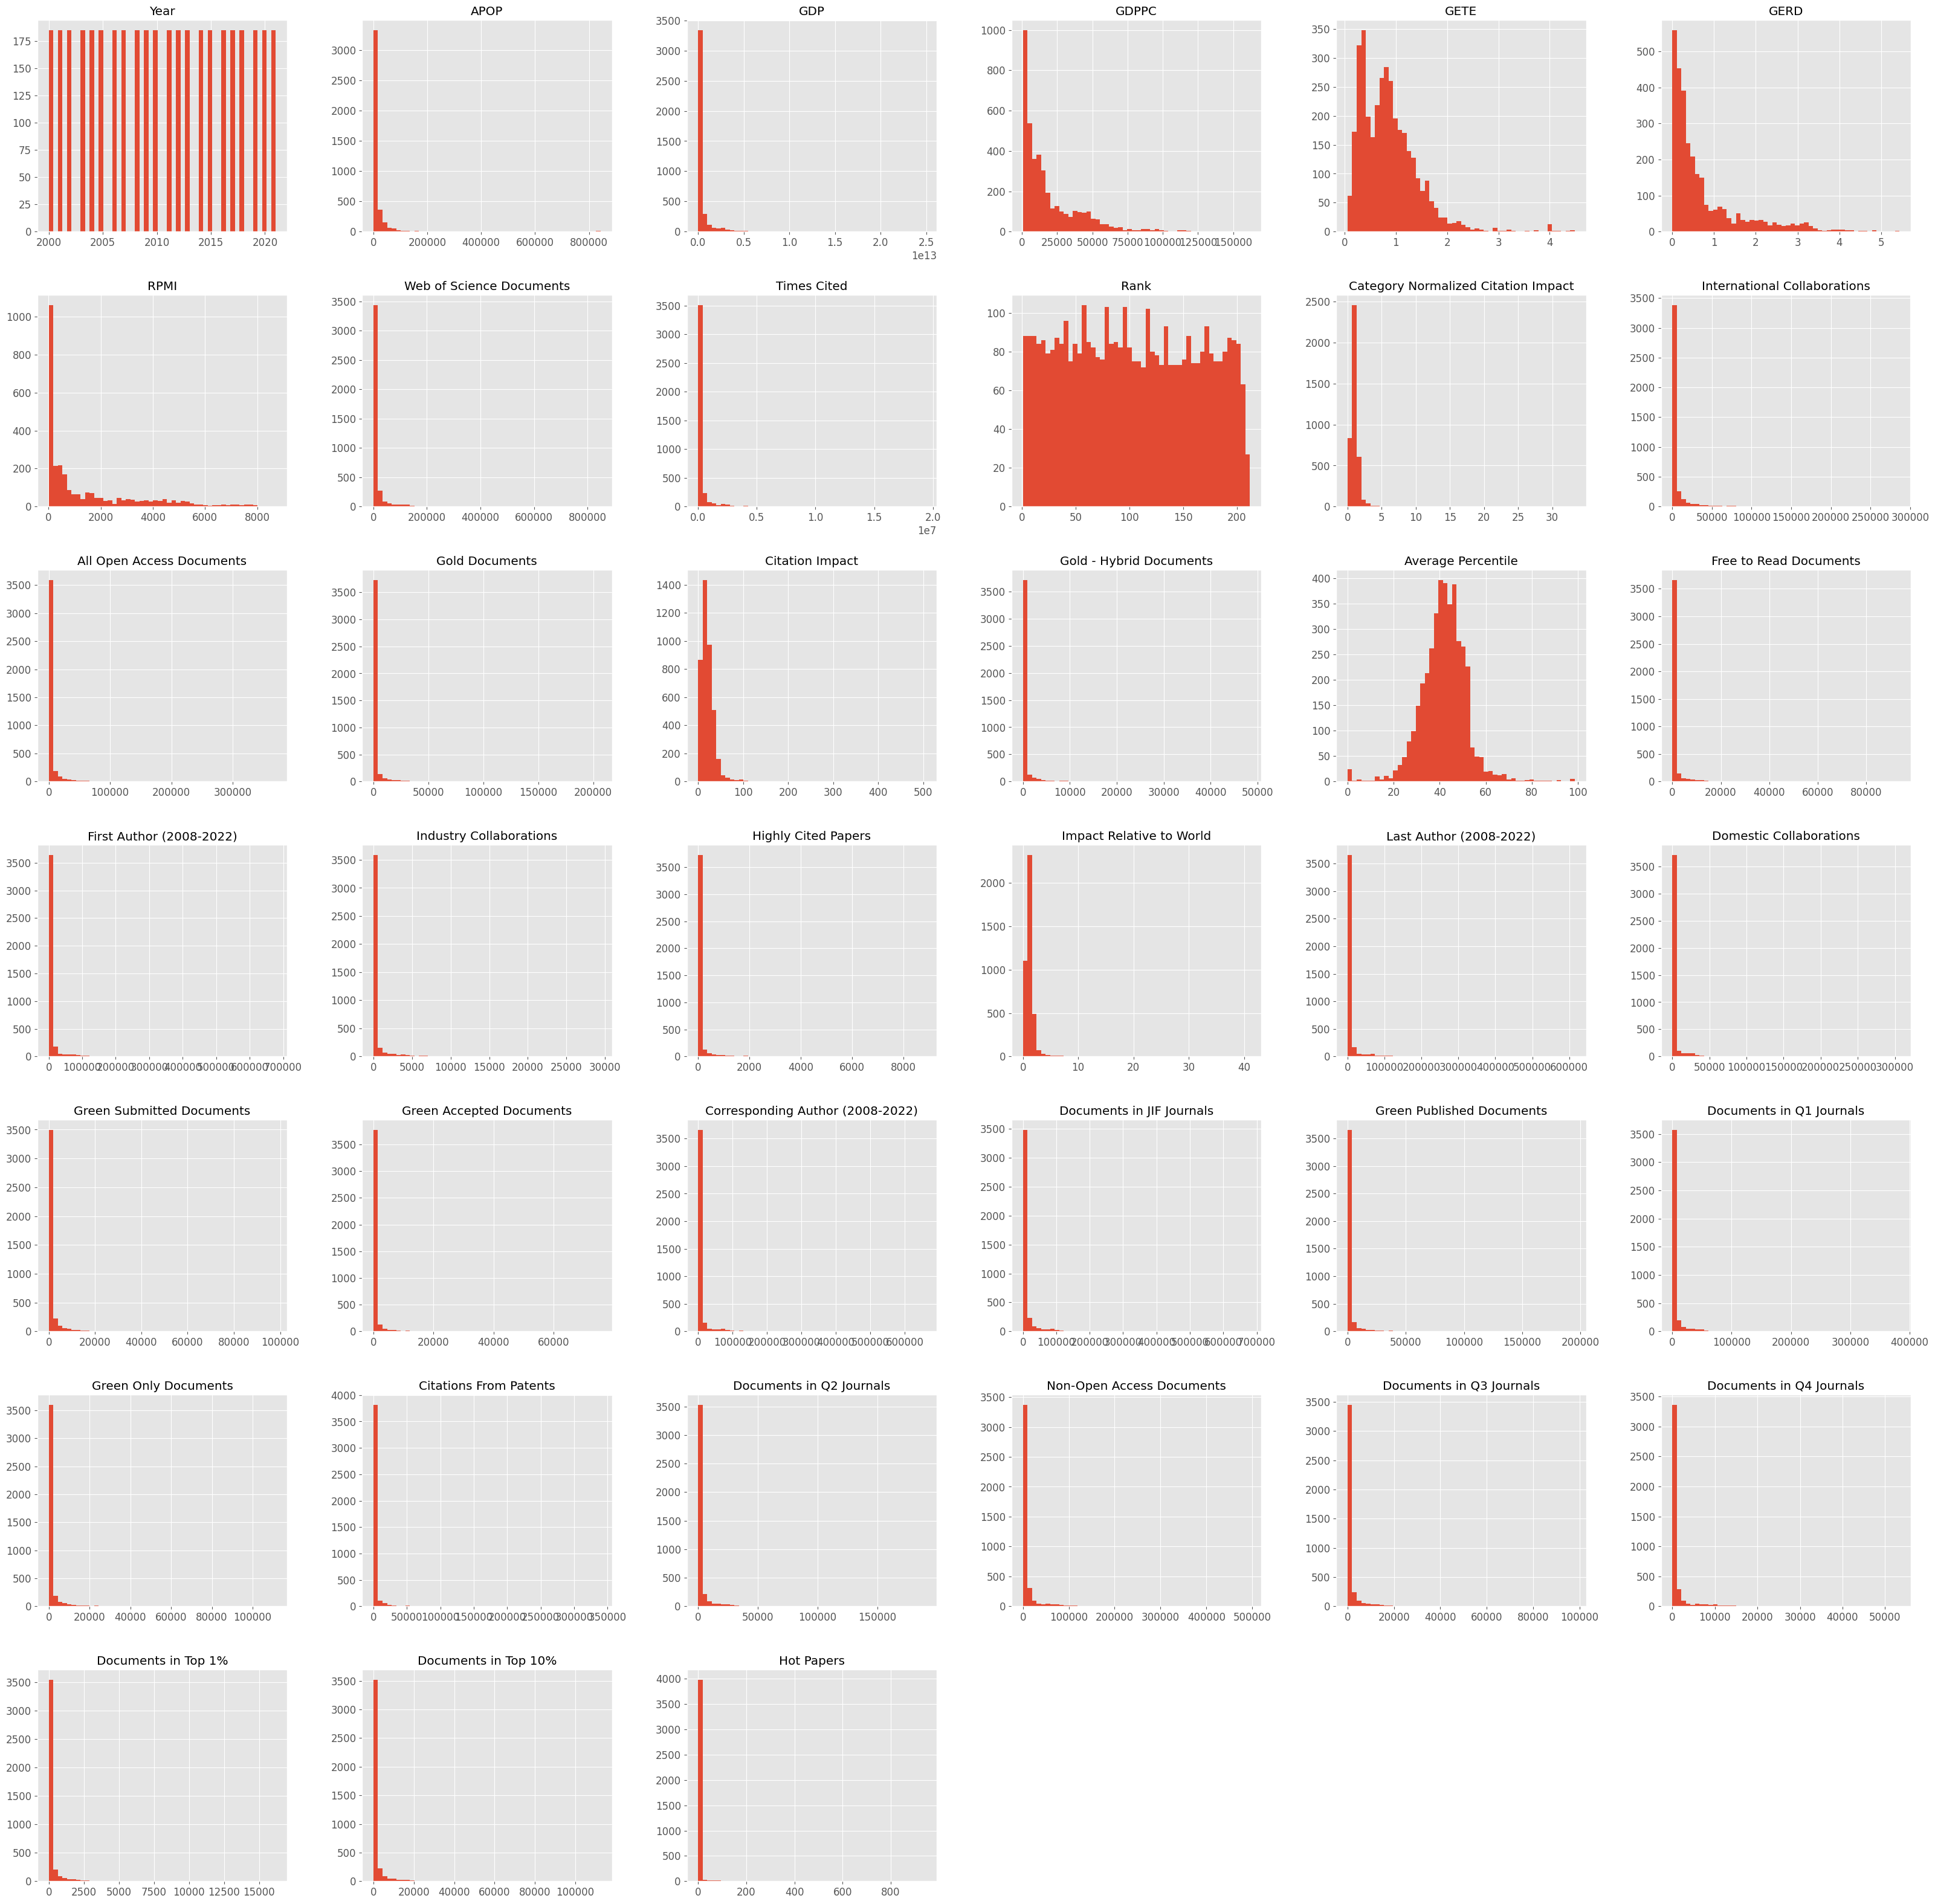

In [34]:
# Plot histograms for each variable, adjusting the number of bins
df.hist(bins=50, figsize=(40,40))
plt.show()

In [35]:
# Drop the column Rank, since the rank is not complete due to countries with missing values that were dropped
df = df.drop(['Rank'], axis=1)

### 6.2 Line Plot Insights

The line chart graphs can explain the evolution of the variables over time, comaparing Brazil to rest of the World. Most variables had a crescend trend, with some exceptions, such as those related to the number of citations. It is natural that the number of citations decreases over time, since the recent publications have less time to be cited.

The graphs also show that some of the variables do not present data for all the years, which is a problem for the analysis. Therefore, this variables were removed from the analysis.

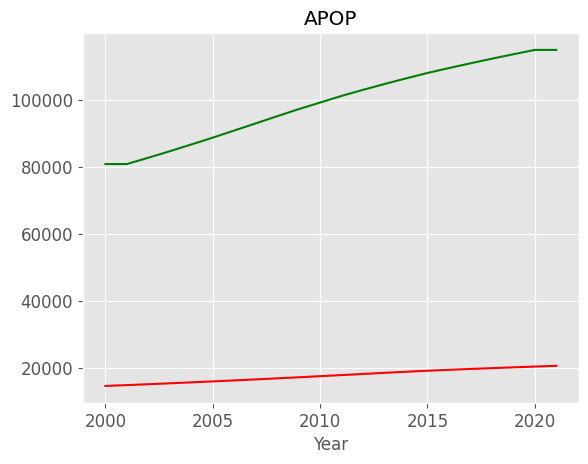

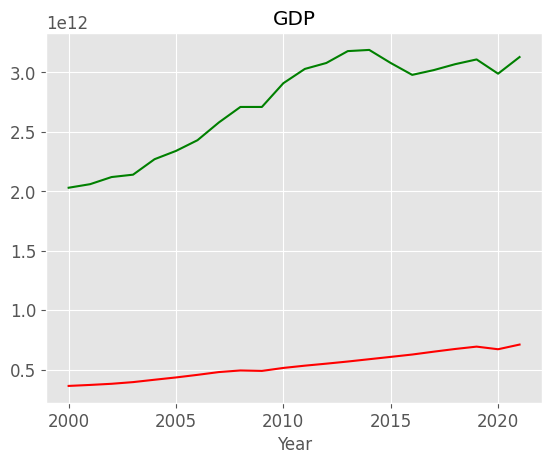

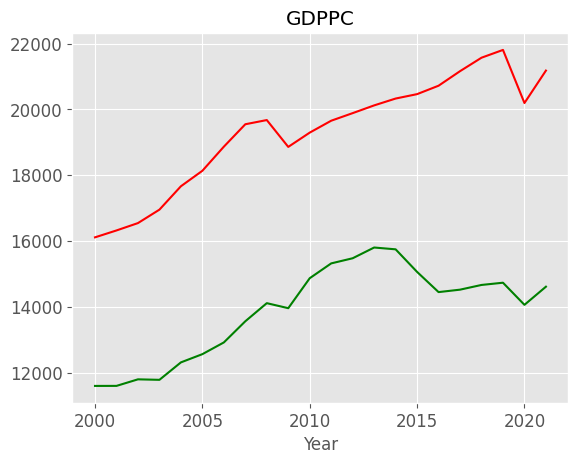

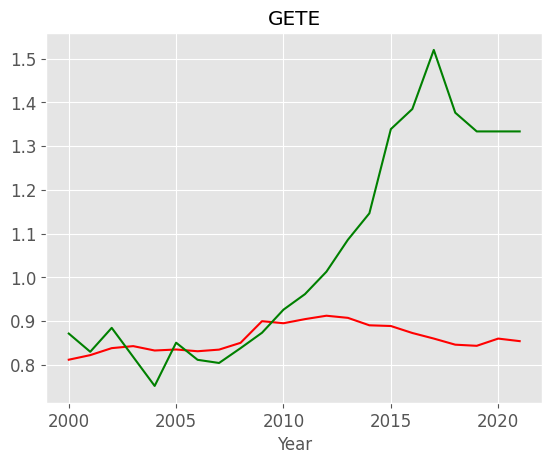

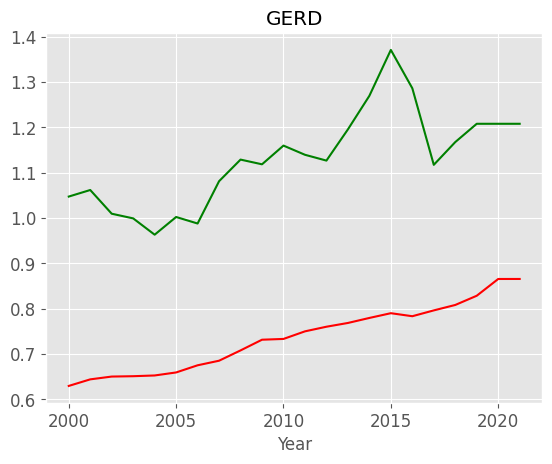

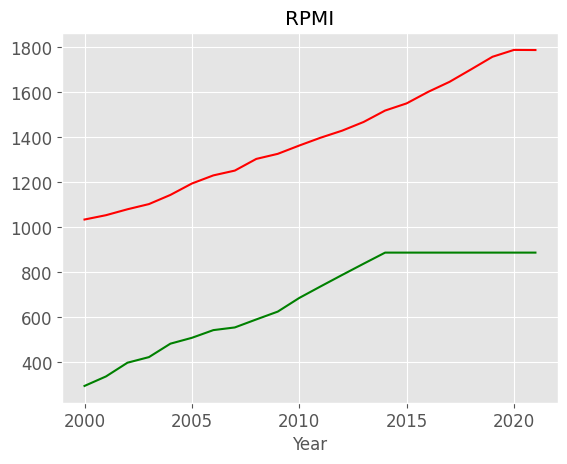

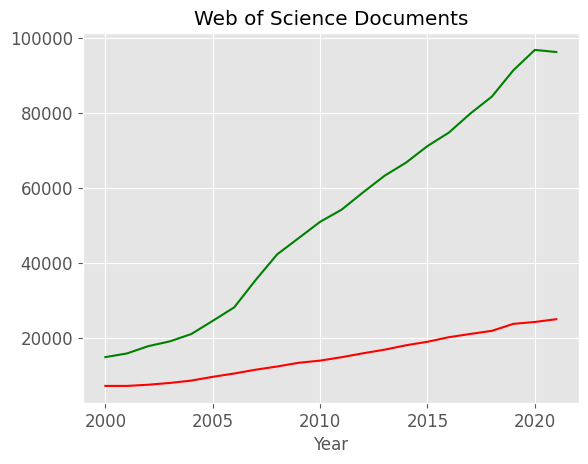

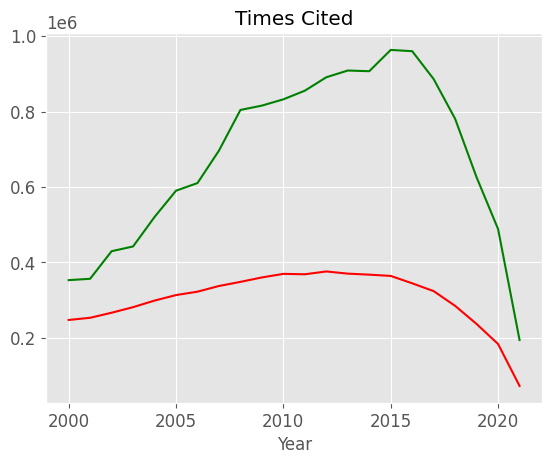

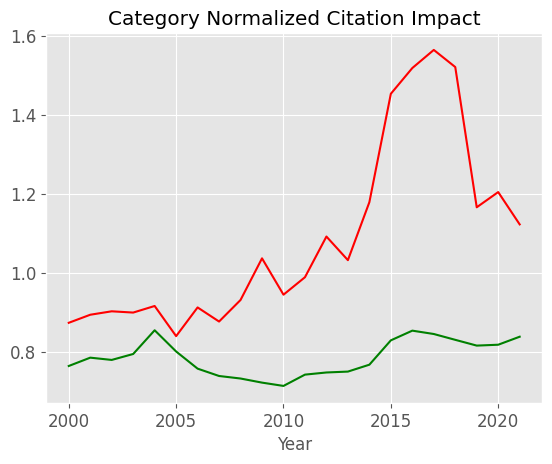

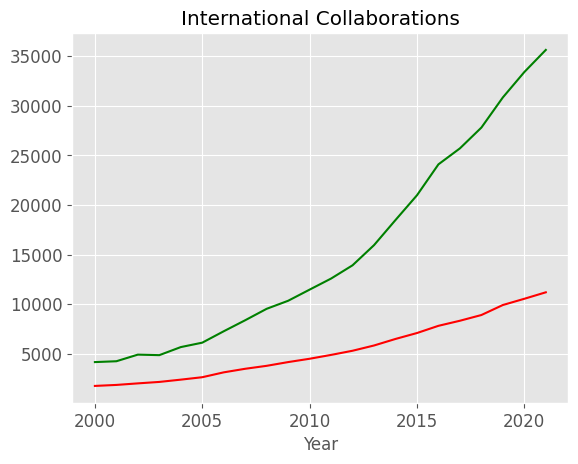

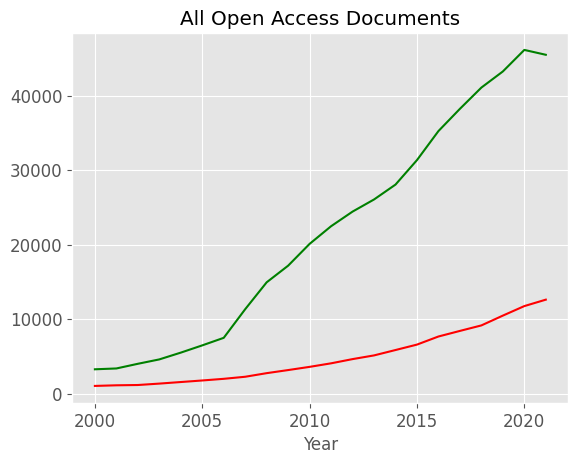

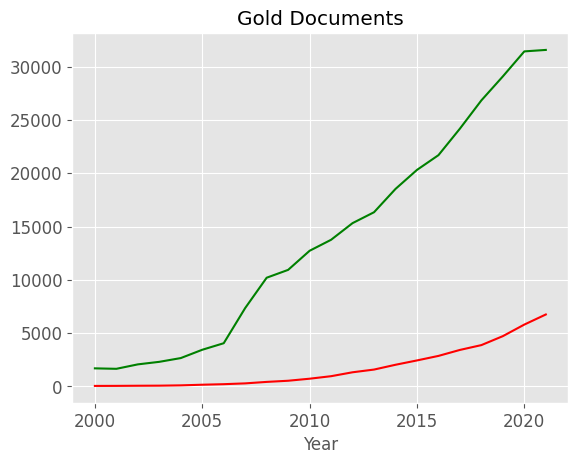

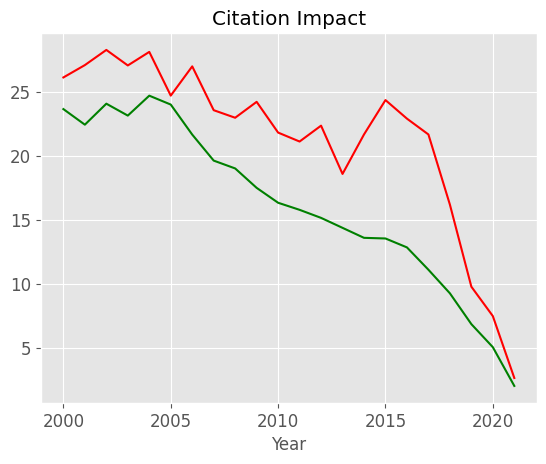

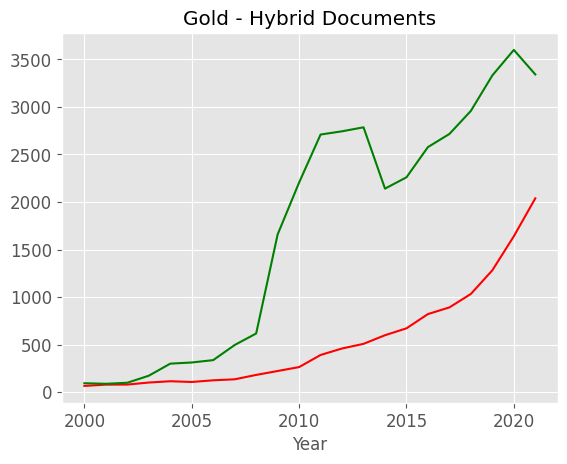

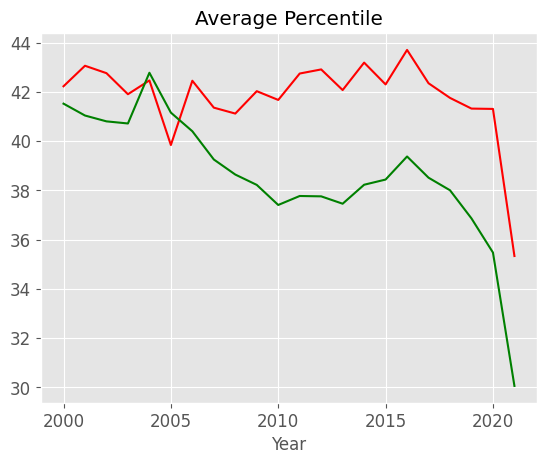

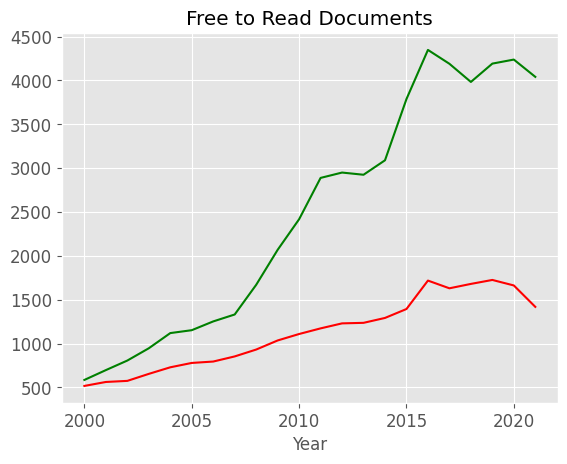

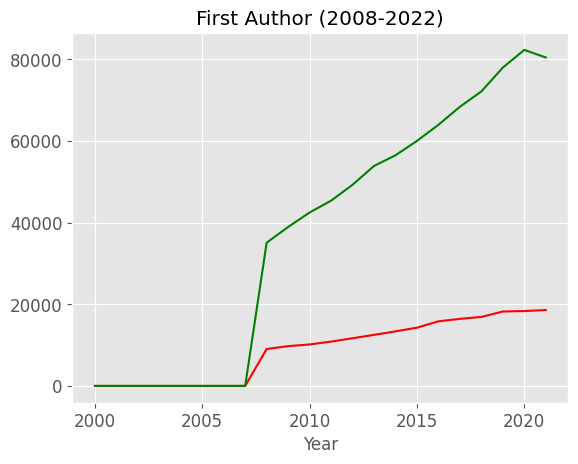

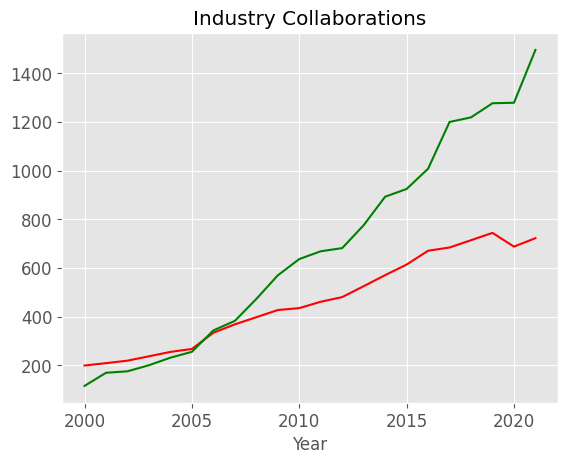

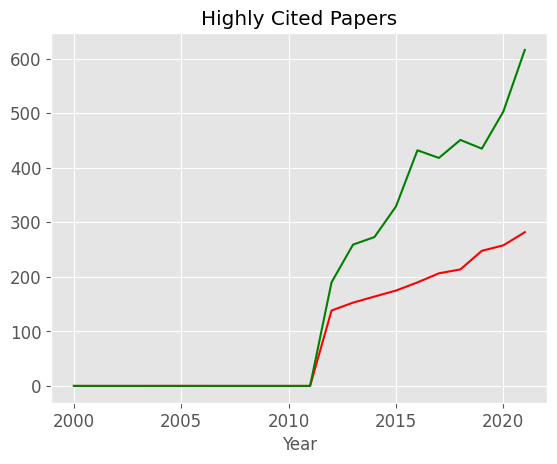

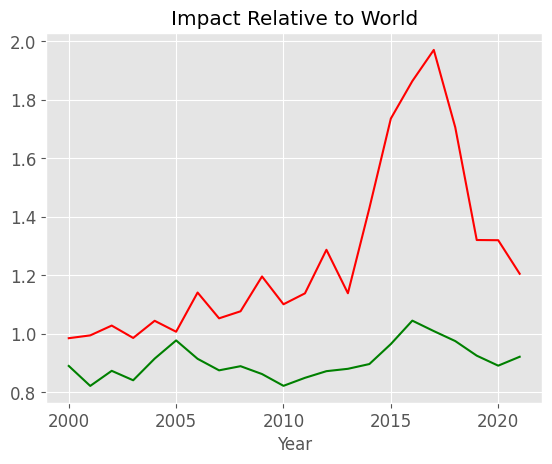

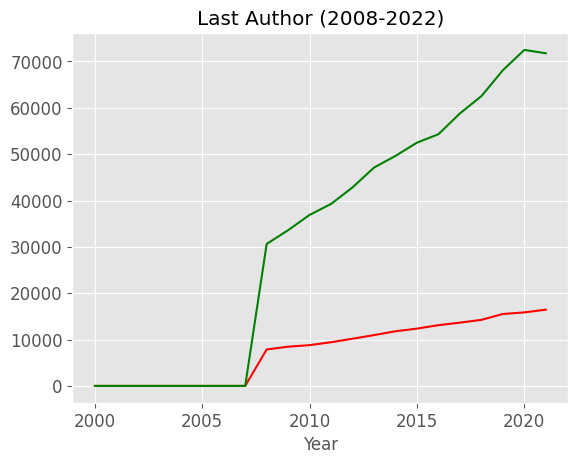

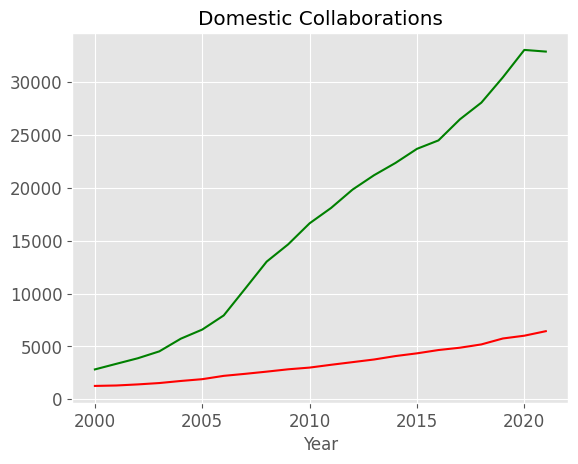

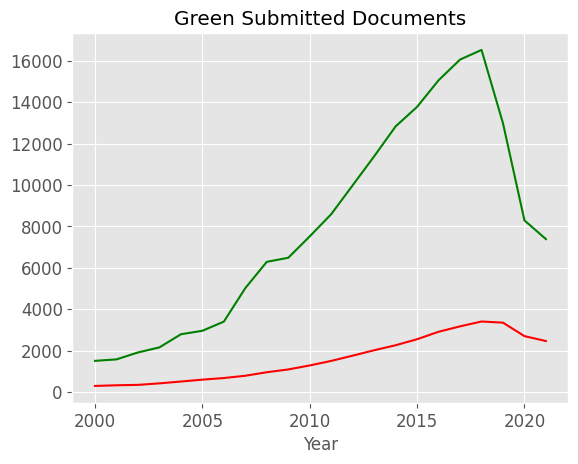

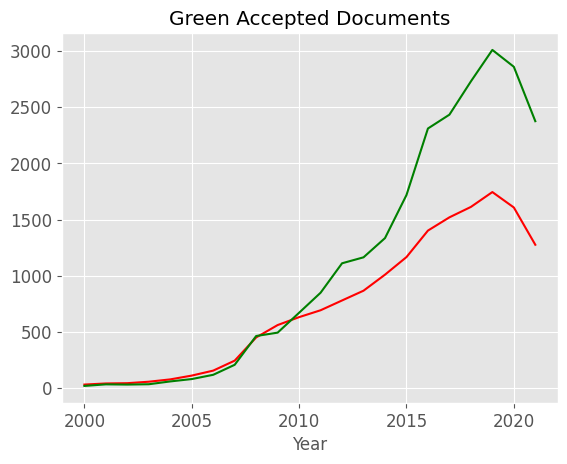

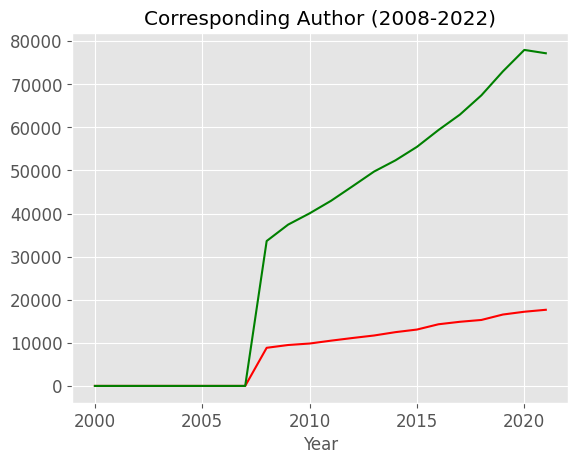

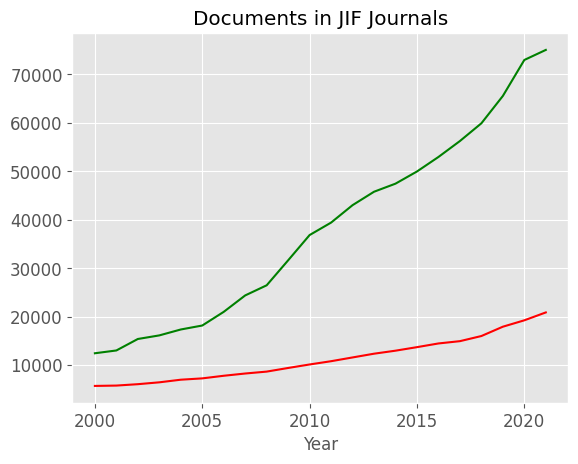

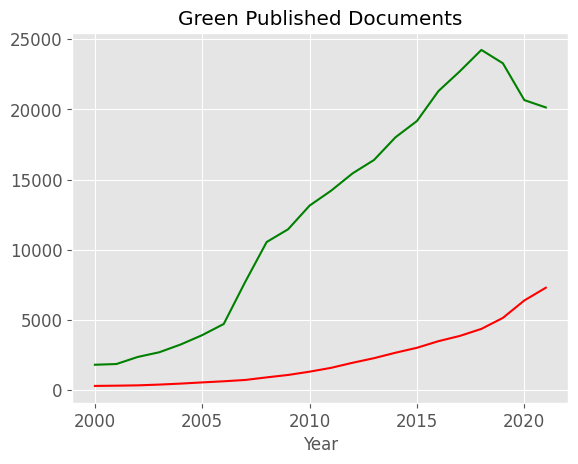

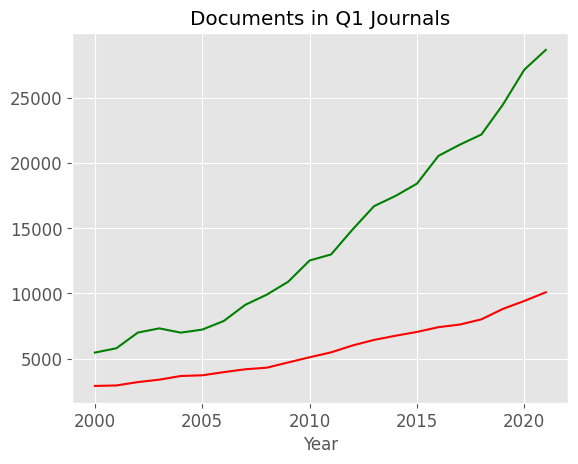

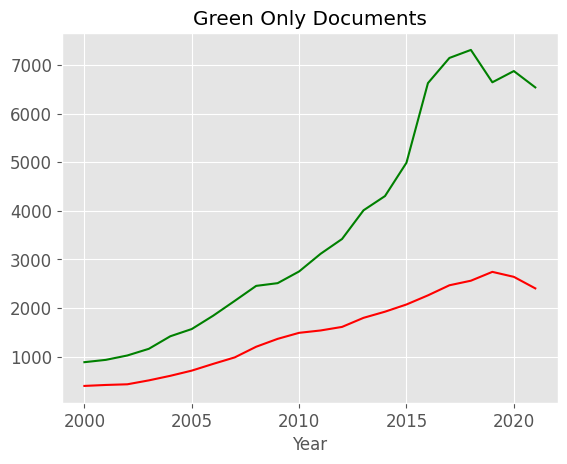

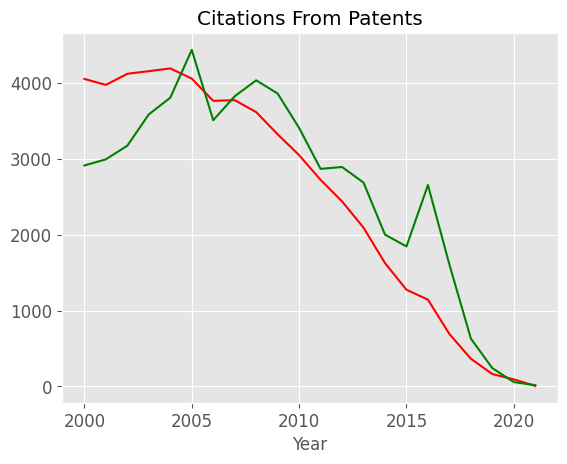

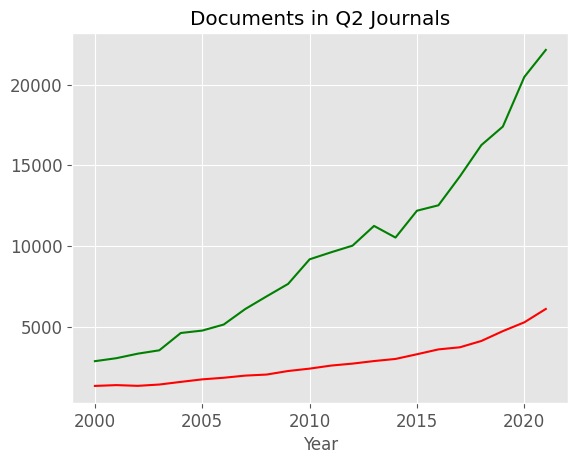

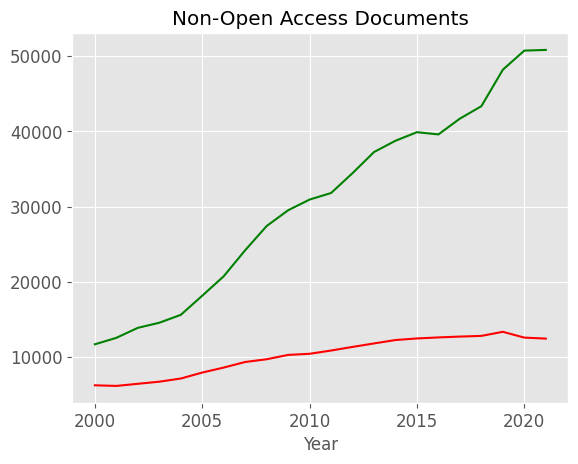

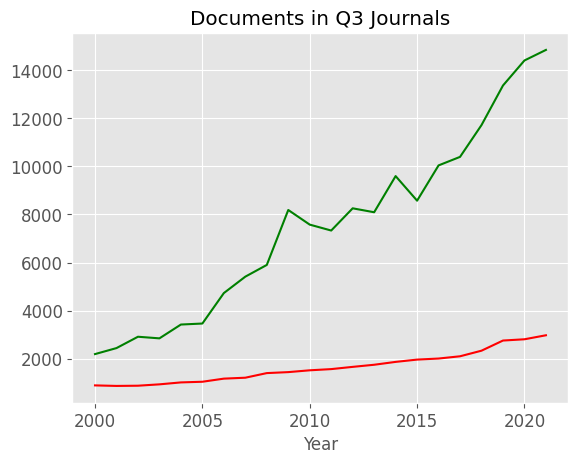

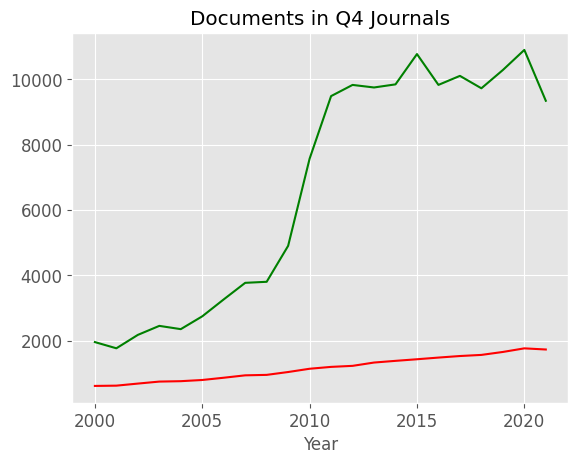

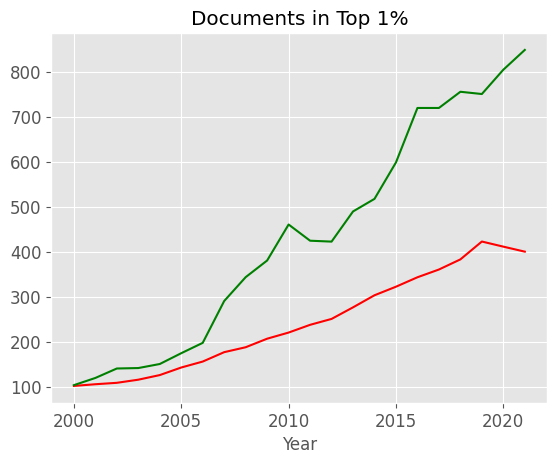

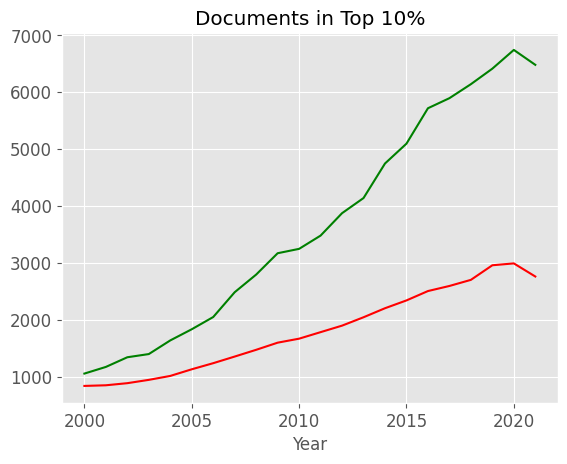

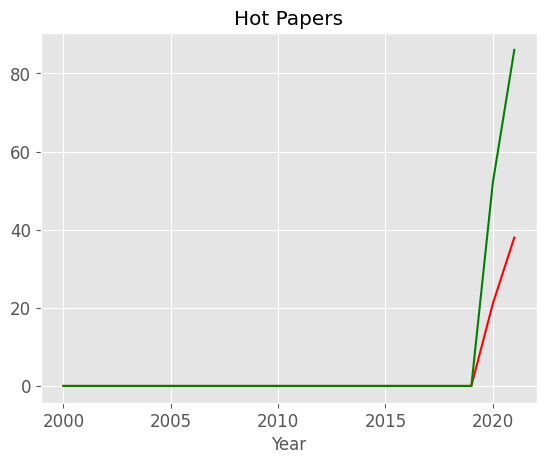

In [36]:
# For each variable after the 5th column, line chart with the valeu of Brazil (in green) vs the World average (in red)
for i in range(5, len(df.columns)):
    df.groupby('Year')[df.columns[i]].mean().plot(color = 'red')
    df[df['Country'] == 'Brazil'].groupby('Year')[df.columns[i]].mean().plot(color = 'green')
    plt.title(df.columns[i])
    plt.show()

In [37]:
# Drop the columns First Author (2008-2022), Last Author (2008-2022), Corresponding Author (2008-2022), Highly Cited Papers and Hot Papers, since they do not have a complete time series  
df = df.drop(['First Author (2008-2022)', 'Last Author (2008-2022)', 'Corresponding Author (2008-2022)', 'Highly Cited Papers', 'Hot Papers'], axis=1)

### 6.3 Correlation Matrix Insights

The correlation matrix shows the correlation between the variables. The correlation between the variables is important to understand the relationship between them. Many of the variables are highly correlated, which is expected, since most of them are related to the scientific production.

In [38]:
# Plot a correlation matrix of 5h column onwards with heat map, with two decimal places
corr_matrix = df.iloc[:, 5:].corr()
corr_matrix.style.background_gradient(cmap='PuBuGn').set_precision(2)

,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web of Science Documents,Times Cited,Category Normalized Citation Impact,International Collaborations,All Open Access Documents,Gold Documents,Citation Impact,Gold - Hybrid Documents,Average Percentile,Free to Read Documents,Industry Collaborations,Impact Relative to World,Domestic Collaborations,Green Submitted Documents,Green Accepted Documents,Documents in JIF Journals,Green Published Documents,Documents in Q1 Journals,Green Only Documents,Citations From Patents,Documents in Q2 Journals,Non-Open Access Documents,Documents in Q3 Journals,Documents in Q4 Journals,Documents in Top 1%,Documents in Top 10%
APOP,1.00,0.71,-0.04,0.05,0.13,-0.02,0.49,0.36,-0.03,0.37,0.38,0.47,-0.04,0.27,-0.03,0.32,0.31,-0.03,0.54,0.35,0.18,0.47,0.37,0.39,0.26,0.20,0.50,0.52,0.58,0.64,0.37,0.41
GDP,0.71,1.00,0.16,0.12,0.36,0.20,0.94,0.81,-0.01,0.82,0.84,0.76,-0.03,0.65,0.00,0.84,0.84,-0.01,0.95,0.79,0.62,0.93,0.79,0.89,0.77,0.60,0.93,0.95,0.95,0.95,0.87,0.89
GDPPC,-0.04,0.16,1.00,0.26,0.51,0.66,0.23,0.24,0.05,0.29,0.23,0.16,0.05,0.24,0.16,0.25,0.28,0.05,0.18,0.26,0.20,0.23,0.23,0.24,0.25,0.17,0.23,0.22,0.21,0.20,0.25,0.25
GETE,0.05,0.12,0.26,1.00,0.36,0.36,0.16,0.15,0.03,0.19,0.16,0.14,0.02,0.16,0.09,0.15,0.17,0.02,0.13,0.17,0.12,0.16,0.16,0.15,0.15,0.10,0.16,0.16,0.16,0.17,0.16,0.16
GERD,0.13,0.36,0.51,0.36,1.00,0.90,0.44,0.41,0.15,0.49,0.42,0.34,0.12,0.40,0.28,0.43,0.50,0.18,0.38,0.45,0.30,0.44,0.41,0.42,0.40,0.30,0.44,0.43,0.44,0.43,0.42,0.43
RPMI,-0.02,0.20,0.66,0.36,0.90,1.00,0.32,0.30,0.14,0.40,0.33,0.24,0.08,0.35,0.24,0.33,0.40,0.19,0.25,0.37,0.26,0.32,0.33,0.32,0.33,0.21,0.32,0.30,0.31,0.29,0.33,0.32
Web of Science Documents,0.49,0.94,0.23,0.16,0.44,0.32,1.00,0.87,0.02,0.95,0.95,0.80,-0.01,0.79,0.05,0.96,0.96,0.01,0.97,0.92,0.80,1.00,0.90,0.99,0.92,0.62,0.99,0.99,0.98,0.92,0.98,0.99
Times Cited,0.36,0.81,0.24,0.15,0.41,0.30,0.87,1.00,0.03,0.75,0.70,0.43,0.05,0.52,0.07,0.85,0.85,0.02,0.78,0.72,0.64,0.85,0.60,0.88,0.79,0.89,0.79,0.92,0.80,0.77,0.88,0.89
Category Normalized Citation Impact,-0.03,-0.01,0.05,0.03,0.15,0.14,0.02,0.03,1.00,0.03,0.03,0.01,0.71,0.03,0.36,0.03,0.03,0.87,0.01,0.03,0.03,0.02,0.03,0.03,0.03,0.02,0.02,0.01,0.01,-0.01,0.03,0.03
International Collaborations,0.37,0.82,0.29,0.19,0.49,0.40,0.95,0.75,0.03,1.00,0.98,0.83,-0.03,0.90,0.07,0.94,0.95,0.03,0.89,0.97,0.86,0.95,0.95,0.94,0.95,0.46,0.95,0.89,0.91,0.85,0.95,0.95


### 7 TUNING THE MODEL

In [48]:
# Create a new dataframe named "dfs", scaling the data on each column of "df" between the 5th and the last three, keeping the first 5 columns (rounding to 2 decimal places)
dfs = df.iloc[:, 5:].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0).round(4)
dfs = pd.concat([df.iloc[:, :5], dfs], axis=1)

# Create a new column in the first position, with a numeric ID for each , starting from 1
dfs['ID'] = dfs.groupby('Country').ngroup()+1

# Drop Year > 2016
dfs = dfs[dfs['Year'] <= 2016]

# Create column "treated", with "True" for Brazil  and "False" for the rest of the countries
dfs['Treatment'] = np.where(dfs['Country'] == 'Brazil', True, False)

# Create column "after_treatment", with "True" for years between 2006 and 2016, and "False" for the rest of the years
dfs['Post'] = np.where((dfs['Year'] >= 2007) & (dfs['Year'] <= 2016), True, False)

# Print first 50 rows of the dataset
dfs.head(20)

# Print Brazil's data
dfs[dfs['Country'] == 'Brazil']

,Country,Code,Region,Income Group,Year,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web of Science Documents,Times Cited,Category Normalized Citation Impact,International Collaborations,All Open Access Documents,Gold Documents,Citation Impact,Gold - Hybrid Documents,Average Percentile,Free to Read Documents,Industry Collaborations,Impact Relative to World,Domestic Collaborations,Green Submitted Documents,Green Accepted Documents,Documents in JIF Journals,Green Published Documents,Documents in Q1 Journals,Green Only Documents,Citations From Patents,Documents in Q2 Journals,Non-Open Access Documents,Documents in Q3 Journals,Documents in Q4 Journals,Documents in Top 1%,Documents in Top 10%,ID,Treatment,Post
25,Brazil,BRA,Latin America & Caribbean,Upper middle income,2000,0.0958,0.0815,0.0680,0.1835,0.1919,0.0332,0.0176,0.0182,0.0230,0.0146,0.0088,0.0082,0.0469,0.0019,0.4210,0.0063,0.0039,0.0217,0.0092,0.0153,0.0003,0.0184,0.0093,0.0143,0.0080,0.0086,0.0151,0.0236,0.0223,0.0367,0.0064,0.0094,23,True,False
238,Brazil,BRA,Latin America & Caribbean,Upper middle income,2001,0.0958,0.0827,0.0680,0.1741,0.1946,0.0381,0.0187,0.0184,0.0236,0.0149,0.0091,0.0080,0.0444,0.0018,0.4161,0.0074,0.0058,0.0200,0.0110,0.0161,0.0004,0.0192,0.0096,0.0151,0.0084,0.0088,0.0160,0.0253,0.0249,0.0332,0.0074,0.0104,23,True,False
451,Brazil,BRA,Latin America & Caribbean,Upper middle income,2002,0.0981,0.0851,0.0692,0.1864,0.1849,0.0451,0.0210,0.0222,0.0234,0.0172,0.0108,0.0100,0.0477,0.0020,0.4137,0.0086,0.0060,0.0213,0.0127,0.0195,0.0004,0.0227,0.0122,0.0183,0.0092,0.0093,0.0175,0.0280,0.0297,0.0408,0.0087,0.0119,23,True,False
664,Brazil,BRA,Latin America & Caribbean,Upper middle income,2003,0.1004,0.0859,0.0691,0.1715,0.1830,0.0479,0.0225,0.0229,0.0239,0.0170,0.0124,0.0112,0.0458,0.0036,0.4128,0.0101,0.0068,0.0205,0.0148,0.0220,0.0005,0.0238,0.0139,0.0191,0.0104,0.0106,0.0186,0.0294,0.0290,0.0460,0.0088,0.0124,23,True,False
877,Brazil,BRA,Latin America & Caribbean,Upper middle income,2004,0.1027,0.0912,0.0724,0.1565,0.1764,0.0548,0.0248,0.0269,0.0257,0.0198,0.0149,0.0129,0.0489,0.0062,0.4337,0.0120,0.0079,0.0223,0.0187,0.0284,0.0008,0.0256,0.0167,0.0183,0.0127,0.0112,0.0242,0.0315,0.0349,0.0441,0.0093,0.0146,23,True,False
1090,Brazil,BRA,Latin America & Caribbean,Upper middle income,2005,0.1052,0.0940,0.0740,0.1788,0.1836,0.0578,0.0290,0.0305,0.0241,0.0214,0.0175,0.0167,0.0476,0.0065,0.4173,0.0123,0.0087,0.0238,0.0215,0.0302,0.0011,0.0268,0.0201,0.0189,0.0141,0.0131,0.0250,0.0366,0.0353,0.0515,0.0108,0.0163,23,True,False
1303,Brazil,BRA,Latin America & Caribbean,Upper middle income,2006,0.1077,0.0976,0.0762,0.1699,0.1810,0.0617,0.0332,0.0316,0.0228,0.0254,0.0202,0.0196,0.0429,0.0070,0.4096,0.0134,0.0117,0.0223,0.0259,0.0347,0.0016,0.0309,0.0242,0.0206,0.0166,0.0103,0.0270,0.0419,0.0483,0.0612,0.0122,0.0182,23,True,False
1516,Brazil,BRA,Latin America & Caribbean,Upper middle income,2007,0.1102,0.1036,0.0802,0.1683,0.1981,0.0631,0.0418,0.0360,0.0222,0.0293,0.0306,0.0356,0.0389,0.0103,0.3980,0.0142,0.0130,0.0213,0.0342,0.0512,0.0027,0.0359,0.0395,0.0238,0.0193,0.0113,0.0320,0.0489,0.0553,0.0707,0.0180,0.0221,23,True,True
1729,Brazil,BRA,Latin America & Caribbean,Upper middle income,2008,0.1127,0.1088,0.0836,0.1760,0.2069,0.0672,0.0499,0.0416,0.0220,0.0333,0.0404,0.0494,0.0377,0.0128,0.3918,0.0178,0.0161,0.0217,0.0426,0.0641,0.0061,0.0390,0.0541,0.0259,0.0221,0.0119,0.0362,0.0554,0.0602,0.0713,0.0212,0.0249,23,True,True
1942,Brazil,BRA,Latin America & Caribbean,Upper middle income,2009,0.1152,0.1088,0.0826,0.1839,0.2050,0.0712,0.0550,0.0422,0.0217,0.0361,0.0464,0.0529,0.0347,0.0343,0.3875,0.0221,0.0194,0.0210,0.0479,0.0661,0.0065,0.0466,0.0588,0.0285,0.0226,0.0114,0.0402,0.0596,0.0836,0.0919,0.0235,0.0282,23,True,True


If we want to go from this table to the matrix representation we discussed earlier, all we have to do is pivot the table by time (year) and unit (Country). We'll be going back and forth between these two representations, as one is more convenient for DiD and the other, for Synthetic Controls estimation. 

In [50]:
dfs_piv = dfs.pivot("Year", "Country", "Web of Science Documents")
dfs_piv = dfs_piv.rename(columns={c: f"{c}" for c in dfs_piv.columns if c != "Brazil"})

dfs_piv.head(17).round(4)

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burundi,Cabo Verde,Cambodia,Cameroon,...,Sudan,Suriname,Swaziland,Sweden,Switzerland,SÃ£o TomÃ© and Principe,Tajikistan,Tanzania,Thailand,The Bahamas,The Gambia,Timor-Leste,Togo,Tonga,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Tuvalu,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Vietnam,Zambia,Zimbabwe
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000,0.0000,0.0001,0.0006,0.0000,0.0,0.0067,0.0005,0.0364,0.0114,0.0002,0.0001,0.0006,0.0001,0.0016,0.0163,0.0,0.0001,0.0000,0.0000,0.0001,0.0001,0.0002,0.0176,0.0000,0.0022,0.0001,0.0000,0.0000,0.0000,0.0003,...,0.0001,0.0000,0.0000,0.0232,0.0220,0.0,0.0000,0.0003,0.0020,0.0000,0.0001,0.0,0.0000,0.0,0.0002,0.0008,0.0082,0.0,0.0,0.0002,0.0062,0.0005,0.1374,0.5134,0.0005,0.0005,0.0000,0.0005,0.0001,0.0003
2001,0.0000,0.0000,0.0006,0.0000,0.0,0.0070,0.0005,0.0372,0.0123,0.0002,0.0001,0.0006,0.0001,0.0015,0.0165,0.0,0.0001,0.0000,0.0000,0.0001,0.0001,0.0002,0.0187,0.0000,0.0022,0.0001,0.0000,0.0000,0.0000,0.0003,...,0.0001,0.0000,0.0000,0.0233,0.0214,0.0,0.0000,0.0003,0.0023,0.0000,0.0001,0.0,0.0000,0.0,0.0002,0.0010,0.0099,0.0,0.0,0.0002,0.0061,0.0006,0.1324,0.5027,0.0005,0.0004,0.0000,0.0005,0.0001,0.0003
2002,0.0000,0.0001,0.0007,0.0000,0.0,0.0071,0.0006,0.0374,0.0125,0.0002,0.0001,0.0006,0.0001,0.0016,0.0173,0.0,0.0001,0.0000,0.0000,0.0001,0.0001,0.0002,0.0210,0.0000,0.0023,0.0001,0.0000,0.0000,0.0000,0.0003,...,0.0001,0.0000,0.0000,0.0236,0.0224,0.0,0.0001,0.0003,0.0028,0.0000,0.0001,0.0,0.0000,0.0,0.0002,0.0011,0.0128,0.0,0.0,0.0002,0.0063,0.0006,0.1323,0.5202,0.0005,0.0005,0.0000,0.0005,0.0001,0.0003
2003,0.0000,0.0001,0.0009,0.0000,0.0,0.0072,0.0006,0.0415,0.0133,0.0003,0.0001,0.0007,0.0001,0.0015,0.0188,0.0,0.0001,0.0000,0.0000,0.0001,0.0001,0.0002,0.0225,0.0001,0.0024,0.0002,0.0000,0.0000,0.0000,0.0004,...,0.0001,0.0000,0.0000,0.0243,0.0240,0.0,0.0000,0.0004,0.0033,0.0000,0.0001,0.0,0.0000,0.0,0.0002,0.0013,0.0156,0.0,0.0,0.0003,0.0059,0.0008,0.1358,0.5464,0.0005,0.0005,0.0000,0.0007,0.0001,0.0003
2004,0.0000,0.0001,0.0011,0.0000,0.0,0.0073,0.0006,0.0437,0.0146,0.0003,0.0001,0.0008,0.0001,0.0014,0.0204,0.0,0.0001,0.0000,0.0000,0.0002,0.0001,0.0002,0.0248,0.0000,0.0025,0.0002,0.0000,0.0000,0.0001,0.0004,...,0.0001,0.0000,0.0000,0.0256,0.0266,0.0,0.0000,0.0004,0.0037,0.0000,0.0001,0.0,0.0000,0.0,0.0002,0.0017,0.0194,0.0,0.0,0.0004,0.0065,0.0008,0.1413,0.5775,0.0006,0.0005,0.0000,0.0007,0.0001,0.0003
2005,0.0000,0.0001,0.0013,0.0000,0.0,0.0083,0.0007,0.0532,0.0163,0.0004,0.0002,0.0009,0.0001,0.0016,0.0226,0.0,0.0001,0.0000,0.0000,0.0002,0.0003,0.0002,0.0290,0.0001,0.0030,0.0002,0.0000,0.0000,0.0001,0.0006,...,0.0002,0.0000,0.0000,0.0277,0.0283,0.0,0.0000,0.0006,0.0045,0.0000,0.0001,0.0,0.0001,0.0,0.0003,0.0019,0.0237,0.0,0.0,0.0005,0.0080,0.0010,0.1606,0.6160,0.0007,0.0005,0.0000,0.0009,0.0002,0.0003
2006,0.0000,0.0001,0.0017,0.0000,0.0,0.0093,0.0007,0.0591,0.0172,0.0004,0.0002,0.0012,0.0001,0.0017,0.0245,0.0,0.0002,0.0000,0.0000,0.0003,0.0003,0.0003,0.0332,0.0001,0.0031,0.0002,0.0000,0.0000,0.0001,0.0006,...,0.0002,0.0000,0.0000,0.0294,0.0318,0.0,0.0001,0.0007,0.0060,0.0000,0.0001,0.0,0.0001,0.0,0.0003,0.0025,0.0272,0.0,0.0,0.0005,0.0086,0.0012,0.1730,0.6467,0.0008,0.0005,0.0000,0.0010,0.0002,0.0003
2007,0.0000,0.0001,0.0021,0.0000,0.0,0.0102,0.0008,0.0638,0.0200,0.0005,0.0002,0.0013,0.0001,0.0019,0.0270,0.0,0.0002,0.0000,0.0000,0.0003,0.0006,0.0004,0.0418,0.0001,0.0041,0.0003,0.0000,0.0000,0.0002,0.0007,...,0.0003,0.0000,0.0000,0.0311,0.0351,0.0,0.0001,0.0007,0.0069,0.0000,0.0001,0.0,0.0001,0.0,0.0003,0.0032,0.0323,0.0,0.0,0.0007,0.0089,0.0015,0.1878,0.6706,0.0009,0.0006,0.0000,0.0012,0.0002,0.0004
2008,0.0001,0.0002,0.0026,0.0000,0.0,0.0119,0.0010,0.0706

In terms of potential outcomes, we can go back to the outcome matrix to review the causal inference goal here. Since the treatment is only rolled out to the treated unit after the treatment period, we observe the potential outcome $Y_0$ everywhere in the matrix, except for the bottom right block. 
 
$$
Y = \begin{bmatrix}
    \pmb{Y}(0)_{pre, co} & \pmb{Y}(0)_{pre, tr} \\
    \pmb{Y}(0)_{post, co} & \pmb{Y}(1)_{post, tr} \\
\end{bmatrix}
$$
 
Our goal is to estimate the $ATT =  \pmb{Y}(1)_{post, tr} -  \pmb{Y}(0)_{post, tr}$. For that, we need to somehow estimate the missing potential outcome $\pmb{Y}(0)_{post, tr}$. In words, we need to know what would have happened to the treated unit at the post-treatment period had it not been treated. With that in mind, a good place to start is by reviewing both Diff-in-Diff and Synthetic Control. At first, it looks like they are each doing very different things to estimate that missing potential outcome. Combining them sure feels weird. However, both methods have more in common than we might think. 

## 8 DIFF-IN-DIFF

In [ ]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


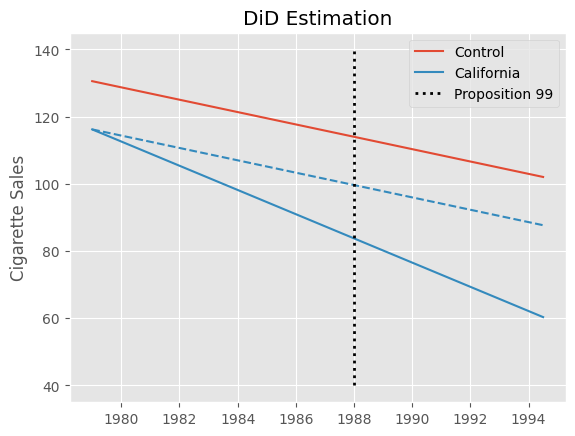

In [ ]:
pre_year = dfs.query("~after_treatment")["year"].mean()
post_year = dfs.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y1 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y0 = post_treat_y1 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel("Cigarette Sales")
plt.legend();

This estimate should be taken with a grain of salt, though. We know that Diff-in-Diff requires the trend in the control group to be equal to that of the treated group in the absence of the treatment. Formally, $E[Y(0)_{post, co} - Y(0)_{pre, co}] = E[Y(0)_{post, tr} - Y(0)_{pre, tr}]$. This is an untestable assumption, but looking at the pre-treatment trend of California (the treated unit) and the other Countrys, we can get a feeling for how plausible it is. Specifically, we can see that the trend in `cigsale` for California is not parallel to the other Countrys, at least in the pre-treatment periods. Cigarette sales in California are decreasing faster than the average of the control Countrys, even prior to the treatment. If this trend extends beyond the pre-treatment period, the DiD estimator will be downward biased, meaning that the true effect is actually less extreme than the one we've estimated above.

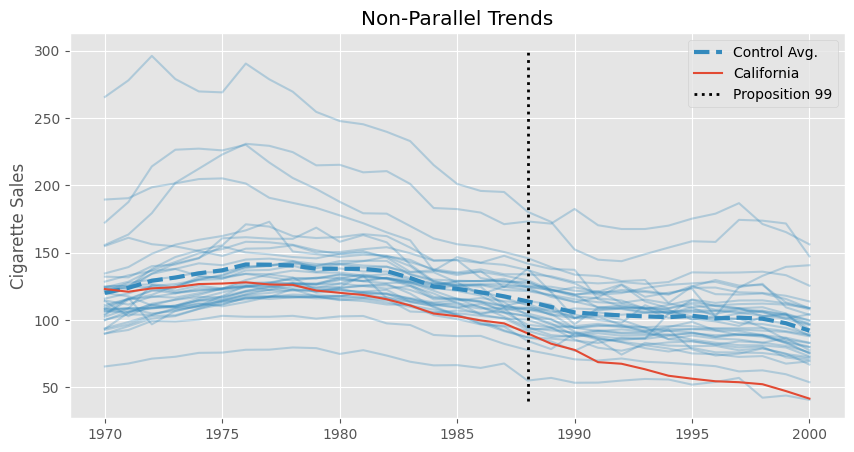

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(dfs_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(dfs_piv.drop(columns=["california"]).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
plt.plot(dfs_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

The problem of non-parallel trends is where Synthetic Control comes into play in the Synthetic Diff-in-Diff model. But we are getting ahead of ourselves. Regardless of DiD being a valid model for the data above, what is interesting about it is that we can recast it into the Two-Way Fixed-Effects formulation. To frame DiD like this, we fit unit ($\alpha_i$) and time ($\beta_t$) averages, alongside the treatment indicator.
 
$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$
 
In this formulation, the unit effects capture the difference in intercepts for each unit while the time effects capture the general trend across both treated and control units. To implement this, we could either add time and unit dummies to the model or demean the dfs. In this process, we subtract the average across both time and units from both treatment and outcome variables:
 
$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_i  - \bar{Y}_t\\
\ddot{D}_{it} = D_{it} - \bar{D}_i - \bar{D}_t
$$
 
Where, $\bar{X}_i$ is the average across all time periods for unit $i$ and $\bar{X}_t$ is the average across all units for time $t$: 
 
$$
\ddot{Y}_{it} = Y_{it} - T^{-1}\sum_{t=0}^{t=T} Y_{it}  - N^{-1}\sum_{i=0}^{i=N} Y_{it}\\
\ddot{D}_{it} = D_{it} - T^{-1}\sum_{t=0}^{t=T} D_{it} - N^{-1}\sum_{i=0}^{i=N} D_{it}
$$
 
After demeaning, a simple regression of the outcome on the treatment indicator (`treat*post`) yields the difference in difference estimator.

In [ ]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("Country")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-119.1647,0.333,-358.379,0.000,-119.817,-118.512
treat,-27.3491,4.283,-6.385,0.000,-35.753,-18.945


## SYNTHETIC CONTROL METHOD (SCM)

In [ ]:
from sc import SyntheticControl

sc_model = SyntheticControl()

y_co_pre = dfs.query("~after_treatment").query("~treated").pivot("year", "Country", "cigsale")
y_tr_pre = dfs.query("~after_treatment").query("treated")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = dfs.query("~treated").pivot("year", "Country", "cigsale").dot(sc_weights)

att = dfs.query("treated")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

SC ATT:  -19.5136


This estimate is much smaller than the one we got with Diff-in-Diff. Synthetic Controls can accommodate non-parallel pre-treatment trends much better, so it is not susceptible to the same bias as Diff-in-Diff. Rather, the process of baking a Synthetic Control enforces parallel trends, at least in the pre-treatment period. As a result, the estimate we get is much smaller and much more plausible. 
 
We can visualize this estimation process by plotting the realized outcome for California alongside the outcome of the synthetic control. We also plot as dashed lines the post intervention average of both California and the synthetic control. The difference between these lines is the estimated $ATT$.

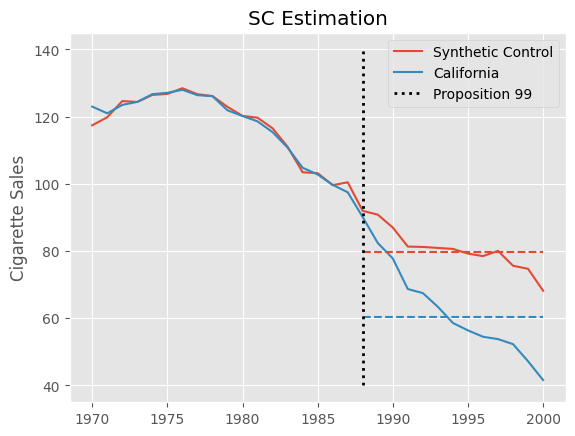

In [ ]:
plt.plot(sc, label="Synthetic Control")
plt.plot(sc.index, dfs.query("treated")["cigsale"], label="California", color="C1")

calif_avg = dfs.query("treated")["cigsale"][sc.index > 1988].mean()
sc_avg = sc[sc.index > 1988].mean()

plt.hlines(calif_avg, 1988, 2000, color="C1", ls="dashed")
plt.hlines(sc_avg, 1988, 2000, color="C0", ls="dashed")

plt.title("SC Estimation")
plt.ylabel("Cigarette Sales")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend();

Interestingly enough, we can also recast the Synthetic Control estimator as solving the following optimization problem, which is quite similar to the Two-Way Fixed-Effects formulation we used for Diff-in-Diff
 
$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$
 
where the $\hat{w}^{sc}_i$ weights for the control units are estimated from the optimization problem we saw earlier. For the treated unit,  the weights are simply $1/N_{tr}$ (unifor weighting). 
 
Notice the difference between SC and DiD here. First, Synthetic Control adds unit weights $\hat{w}^{sc}_i$ to the equation. Second, we have time fixed effects $\beta_t$ but no unit fixed effect $\alpha_i$, nor an overall intercept  $\mu$. 
 
To verify that these two formulations are actually equivalent, here is the code for it, which yields the exact same $ATT$ estimate. 

In [ ]:
@curry
def demean_time(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

data_w_cs_weights = dfs.set_index("Country").join(sc_weights).fillna(1/len(sc_weights))

formula = f"""cigsale ~ -1 + treat"""

mod = smf.wls(formula,
              data=data_w_cs_weights
              .assign(treat = data_w_cs_weights["after_treatment"]*data_w_cs_weights["treated"])
              .pipe(demean_time(col_to_demean="treat"))
              .pipe(demean_time(col_to_demean="cigsale")),
              weights=data_w_cs_weights["sc_w"]+1e-10)

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,-19.5136,13.289,-1.468,0.142,-45.586,6.559


We just saw how the two approaches, SC and DiD, are actually closely related. Now, we are ready to talk about Synthetic Diff-in-Diff. As you can probably guess, we will just add weights to the DiD estimator or unit fixed-effects to the Synthetic Control estimator. 
 
![img](data/img/sdid/both-pills.png)
 
## Synthetic Diff-in-Diff
 
Before we jump right into the Synthetic Diff-in-Diff estimator, let me just reproduce the same equations we saw earlier for SC and DiD, which will ease the comparison.
 
$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$
 
$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$
 
Next, just like I promised, we can easily merge the equations above into one which will contains elements from both of them:
 
$$
\hat{\tau}^{sdid} = \underset{\mu, \alpha, \beta, \tau}{argmin}  \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \hat{w}^{sdid}_i \hat{\lambda}^{sdid}_t \bigg\}
$$
 
As you can see, we've added back the $\alpha_i$ unit fixed effects. We've also kept the unit weights $\hat{w}_i$. But there is something new, which is the time weights $\hat{\lambda}_t$. Don't worry. There is nothing fancy about them. Remember how the unit weights $w_i$ minimized the difference between the control units and the average of treated units? In other words, we use them to match the pre-trend of the treated and control groups. The time weight does the same thing, but for the periods. That is, it minimizes the difference between the pre and post-treated periods. 
 
$$
\hat{\lambda}^{sdid} = \underset{\lambda}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{post, co} - (\pmb{\lambda}_{pre} \pmb{Y}_{pre, co} +  \lambda_0)||^2_2 \\
\text{s.t } \ \sum \lambda_t = 1 \text{ and } \ \lambda_t > 0 \ \forall \ t
$$
 
Again, $\pmb{Y}_{pre, co}$ is a $T_{pre}$ by $N_{co}$ matrix of outcomes where the rows represent time periods and the columns represent the units. But now $\bar{\pmb{y}}_{post, co}$ is a 1 by $N_{co}$ row vector, where each entry is the time average outcome for that control unit in the post-treatment period. Finally, $\pmb{\lambda}_{pre}$ is a 1 by $T_{pre}$ row vector, with one entry for each pretreatment period. Another way to see this is by noticing that the unit weights $w$ where multiplying after the outcome matrix $\pmb{Y}_{pre, co} \pmb{w}_{co}$. This means we where regressing the average outcome **for each unit** for the treated group on the outcome of the units in the control group. Now, we are flipping that problem on its head, regressing the average outcome **for each post-treatment time period** for the control group on the outcome of the same control units, but on the pre-treatment period.
 
As for the time weights in the post-treated periods, we just set them to one over the number of post-treated periods $1/T_{post}$ (again, doing uniform weighting). Notice that we also have an intercept $\lambda_0$. We do this to allow the post-treatment period to be above or below all the pre-treatment periods, which is the case in many applications with a clear positive or negative trend.
 
If all of this seems a bit abstract, maybe code will help you understand what is going on.

In [ ]:
def fit_time_weights(data, outcome_col, year_col, Country_col, treat_col, post_col):
        
        control = dfs.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(year_col, Country_col, outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(Country_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        
        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

The first thing we do in this code is to filter out the treated group. Then, we pivot the pre-treated data so that we have the matrix $\pmb{Y}_{pre,co}$. Next, we group the post-treatment data to get the average outcome for each control unit in the post-treatment period. We then add a row full of ones to the top of $\pmb{Y}_{pre,co}$, which will serve as the intercept. Finally, we regress $\bar{\pmb{y}}_{post, co}$ on the pre-treated periods (the rows of $\pmb{Y}_{pre,co}$) to get the time weights $\lambda_t$. Notice how we add the constraints to have the weights sum up to 1 and be non-negative. Finally, we toss the intercept away and store the time weights in a series. 
 
Here is the result we get by running the code above to find the time weights in the Proposition 99 problem. Notice that all periods except for 1986, 87 ans 88 get zero weights. This means that a weighted average of only the last 3 periods is enough to balance pre and post treatment periods.

In [ ]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                Country_col="Country",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

year
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

To understand a bit more about the role of these weights, we can plot $\hat{\pmb{\lambda}}_{pre} \pmb{Y}_{pre, co} +  \hat{\lambda}_0$ as a horizontal line in the pretreatment period that doesn't get zeroed out. Next to it, we plot the average outcome in the post-treatment period. Notice how they align perfectly. We also show the estimated time weights in red bars and in the secondary axis.

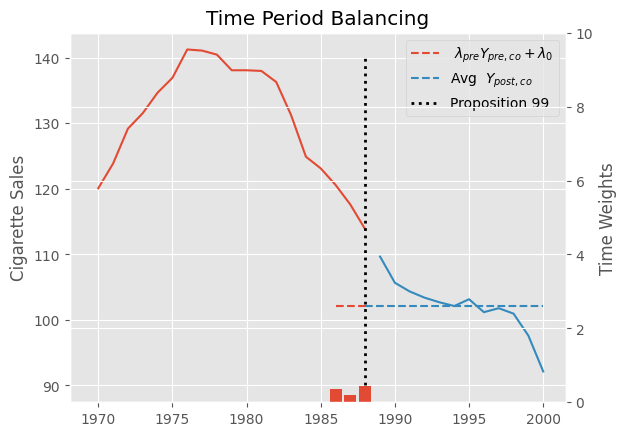

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(dfs.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean())
ax.plot(dfs.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean())

intercep = -15.023877689807628
ax.hlines((dfs.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean() * time_weights).sum() - 15, 1986, 1988,
          color="C0", ls="dashed", label=""" $\lambda_{pre} Y_{pre, co} + \lambda_0$""")
ax.hlines(dfs.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean().mean(), 1988, 2000,
          color="C1", ls="dashed", label="""Avg  $Y_{post, co}$""")
ax.vlines(x=1988, ymin=90, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()

plt.title("Time Period Balancing")
plt.ylabel("Cigarette Sales");

ax2 = ax.twinx()
ax2.bar(time_weights.index, time_weights, label="$\lamba$")
ax2.set_ylim(0,10)
ax2.set_ylabel("Time Weights");

Now that we learned what are the time weights $\lambda_t$ in the Synthetic Diff-in-Diff estimator and how to estimate them, let's turn our attention to the unit weights $w_i$. And no, unfortunately they are not just like the ones we get when using traditional Synthetic Controls. The first difference between them is that we also allow for an intercept $w_0$. We do this because we don't need the treated unit and synthetic control to have the same level anymore. Since we will throw DiD into the mix, we only need to make the synthetic control and treated unit have parallel trends.
 
The next difference is that we add a $L_2$ penalty to the weights. This helps non-zero weights to be more distributed across the control units, as opposed to having just a few of them contributing to the synthetic control. The $L_2$ penalty ensures we don't have very big weights, which forces us to use more units. 
 
 
$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{pre, tr} - (\pmb{Y}_{pre, co} \pmb{w}_{co} +  w_0)||^2_2 + \zeta^2 T_{pre} ||\pmb{w}_{co}||^2_2\\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$


There is also this $\zeta^2$ term, which is theoretically motivated, but very complicated to explain, so I will unfortunately leave it as a bit of a mystery. In the reference, you can check the original article, which explains them. We define it like this:
 
$$
\zeta = (N_{tr}* T_{post})^{1/4}\sigma(\Delta_{it})
$$
 
where $\Delta_{it}$ is the first difference in the outcomes $Y_{it} - Y_{i(t-1)}$ and $\sigma(\Delta_{it})$ is the standard deviation of this difference. Here is the code to compute it.

In [ ]:
def calculate_regularization(data, outcome_col, year_col, Country_col, treat_col, post_col):
    
    n_treated_post = dfs.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .groupby(Country_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

As for the unit weights, there is nothing particularly new in them. We can reuse a lot of the code from the function to estimate the time weights. We only need to be careful about the dimensions, since the problem is now upside down.

In [ ]:
def fit_unit_weights(data, outcome_col, year_col, Country_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, Country_col, treat_col, post_col)
    pre_data = dfs.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(year_col, Country_col, outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

First, we calculate $\zeta$ using the functions we defined earlier and filter out the post-treatment period. Next, we pivot the pre-treatment data to get the $\bar{\pmb{y}}_{pre, tr}$ matrix of outcomes. Then, we add a column full of ones to the beginning of the $\bar{\pmb{y}}_{pre, tr}$ matrix. This column will allow us to estimate the intercept. With all of that, we define the optimization objective, which includes the $L_2$ penalty on the weights. Finally, we toss the intercept away and store the estimated weights in a series.
 
If we use this code to estimate the unit weights in the Proposition 99 problem, here is the result we get for the first 5 Countrys:

In [ ]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                Country_col="Country",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3).head()

state
1   -0.000
2   -0.000
4    0.057
5    0.078
6    0.070
Name: unit_weights, dtype: float64

These unit weights also define a synthetic control that we can plot alongside the outcome of California. We'll also plot the traditional synthetic control we've estimated earlier alongside the one we've just estimated plus the intercept term. This will give us some intuition on what is going on and the difference between what we just did and traditional Synthetic Control.

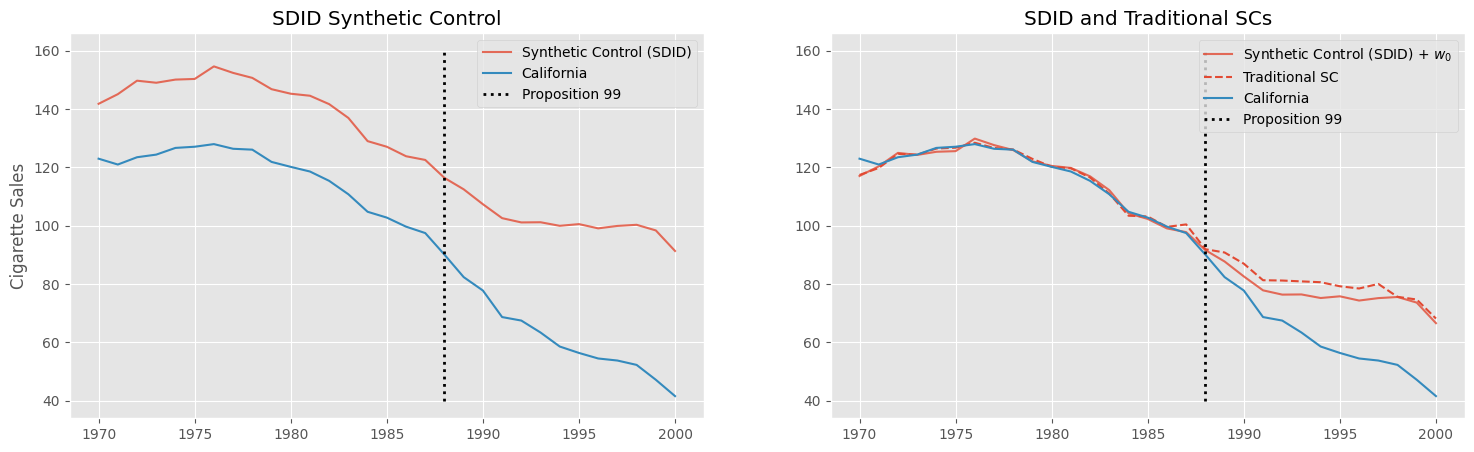

In [ ]:
intercept = -24.75035353644767
sc_did = dfs_piv.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.plot(dfs_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
ax1.plot(dfs_piv["california"], label="California", color="C1")
ax1.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")

ax1.legend()
ax1.set_title("SDID Synthetic Control")
ax1.set_ylabel("Cigarette Sales");

ax2.plot(dfs_piv.index, sc_did+intercept, label="Synthetic Control (SDID) + $w_0$", color="C0", alpha=.8)
ax2.plot(dfs_piv.index, sc, label="Traditional SC", color="C0", ls="dashed")
ax2.plot(dfs_piv["california"], label="California", color="C1")
ax2.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
ax2.legend()
ax2.set_title("SDID and Traditional SCs");

As we can see in the first plot, the obvious difference is that this new synthetic control is no longer on top of California. That's because we've included an intercept, which allows the treated unit to be on an arbitrarily different level than its synthetic control. This new Synthetic Control method is built to have the same pretreatment trend as the treated unit, but not necessarily the same level. 
 
In the second plot, we shift this new SC by adding back the intercept we've removed earlier. This puts it on top of the treated unit, California. For comparison, we show the traditional SC we've fitted earlier as the red dashed line. Notice that they are not the same. This difference comes both from the fact that we allowed for an intercept and from the $L_2$ penalty, which pushed the weights towards zero.
 
Now that we have both time $\hat{\lambda}_t$ and unit $\hat{w}_t$ weights, we can proceed to running the Diff-in-Diff part of the Synthetic DiD estimator. For this part, it is better if we work with the data in the format of a table with $N$ by $T$ rows, where we have columns for the Countrys, the years, the outcome, the post-treatment indicator and the treated unit indicator. To that table, we will add the time and unit weights. Since the time weight is in a series with a time index and the unit weights is in another series with unit index, we can simply join everything together.

In [ ]:
def join_weights(data, unit_w, time_w, year_col, Country_col, treat_col, post_col):

    return (
        data
        .set_index([year_col, Country_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: data[post_col].mean(),
                 unit_w.name: data[treat_col].mean()})
        .assign(**{"weights": lambda d: (d[time_w.name]*d[unit_w.name]).round(10)})
        .astype({treat_col:int, post_col:int}))

This joining process will leave `null` for the unit weights in the treated group and for the time weights in the post-treatment period. Fortunately, because we use uniform weighting in both cases, it is pretty easy to fill out those `null`s. For the time weights, we fill with the average of the post-treatment dummy, which will be $1/T_{post}$; for the unit weights, we fill with the average of the treated dummy, which will be $1/N_{tr}$. Finally, we multiply both weights together.
 
Here is result we get by running this code in the Proposition 99 data:

In [ ]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        Country_col="Country",
                        treat_col="treated",
                        post_col="after_treatment")

did_dfs.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600034e-14,-1.360835e-16,0.0
1,1971,1,95.400002,0,0,-4.582315e-14,-1.360835e-16,0.0
2,1972,1,101.099998,0,0,-5.274190e-14,-1.360835e-16,0.0
3,1973,1,102.900002,0,0,-5.766356e-14,-1.360835e-16,0.0
4,1974,1,108.199997,0,0,-5.617979e-14,-1.360835e-16,0.0


Finally, all we have to do is estimate a Diff-in-Diff model with the weights we've just defined. The parameter estimate associated with the interaction term for the post-treatment period and treated dummy will be the Synthetic Difference-in-Differences estimate for the $ATT$.

In [ ]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

did_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.965,61.278,0.000,116.551,124.261
after_treatment,-19.1905,2.166,-8.859,0.000,-23.440,-14.941
treated,-25.2601,12.427,-2.033,0.042,-49.641,-0.879
after_treatment:treated,-15.6054,13.700,-1.139,0.255,-42.483,11.272


This estimate is much smaller than the one we get with Diff-in-Diff, but that is not surprising. As we've already discussed, the Diff-in-Diff estimator is probably biased in this case, since we have pretty good reasons to question the parallel trends assumption. What is perhaps less obvious is why the SDID estimate is smaller than the traditional SC estimate. If go back and look at the SC plot, we can see that cigarette sales in California started to fall below its synthetic control prior to Proposition 99. This is probably due to the fact that traditional Synthetic Control has to match treated and control units in the entire pre-treatment period, causing it to miss one year or the other. This is less of an issue in SDID, since the time weights allow us to focus just on the periods that are more similar to the post-intervention period. In this case, those were precisely the three years anteceding Proposition 99. 
 
To grasp what SDID is doing, we can plot the Diff-in-Diff lines for the treated (California) and the SDID Synthetic Control. Notice how we are projecting the trend we see in the synthetic control onto the treated unit to get the counterfactual $Y(0)_{tr, post}$. The difference between the two solid purple lines is the estimated $ATT$. We start those lines in 1987 to show how the time weights zero out all periods but 1986, 87 and 88. The time weights are also shown in the small plot down below.

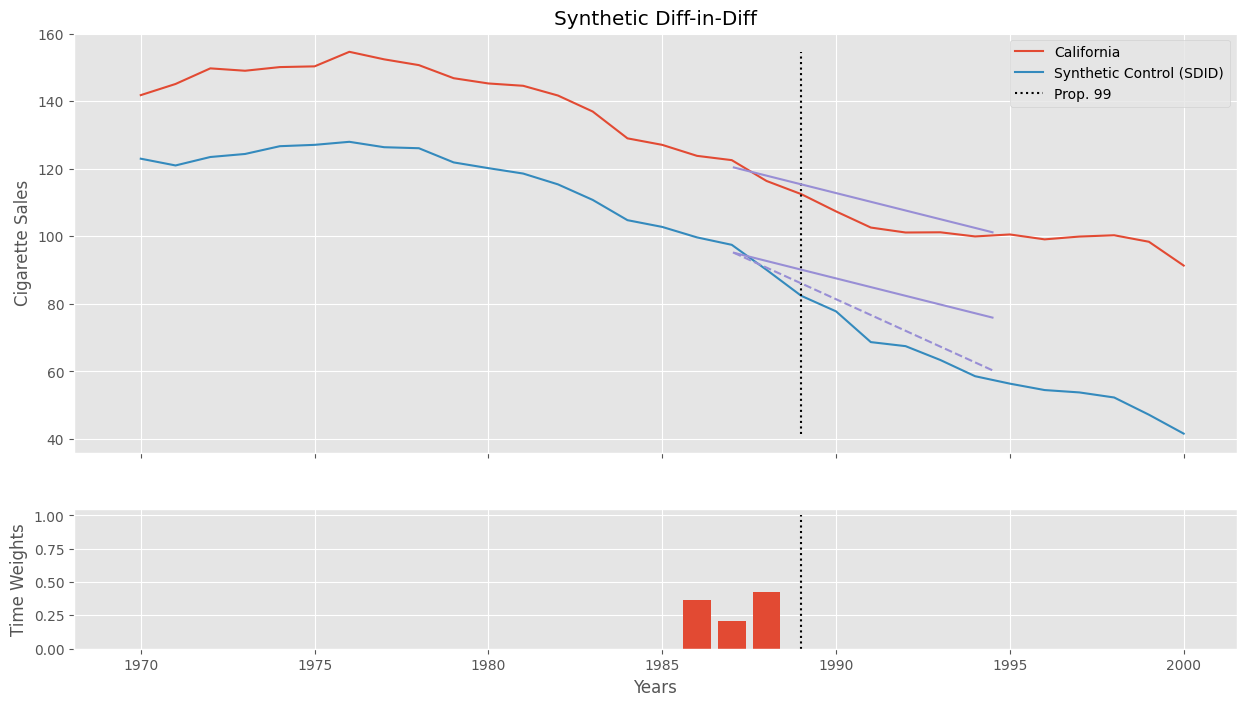

In [ ]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(dfs_piv.index, sc_did, label="California")
ax1.plot(dfs_piv.index, dfs_piv["california"], label="Synthetic Control (SDID)")
ax1.vlines(1989, dfs_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")
ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

The above estimator estimates the $ATT$ which is the effect of Propostion 99 on California averaged out across all post-treatment time periods. But, from the above plot, it looks like the effect increases over time. What if we want to take that into account? Fortunately, it is very straightforward to do that.
 
Before we move on, just a word of caution about the above estimator. You should trust those standard error or confidence intervals, reported by the regression we just ran. They don't consider the variance in estimating the weights. We will take a look at how to do proper inference briefly, but first, lets see how to deal with effect heterogeneity across time
 
## Time Effect Heterogeneity and Staggered Adoption
 
Fortunately, it is incredibly easy to estimate one effect for each time period using SDID. All we have to do is run it multiple times, one for each time period. To be more precise, let's say we have the following treatment assignment matrix, with just 4 time periods and 3 units. The last unit is the treated one.
 
$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$
 
Running SDID with the above matrix would give us the average $ATT$ across periods 3 and 4. What we can do to estimate the effect on each period individually is simply to partition the problem into two, one for each post-treatment time period. Then, we run SDID on the data where we only keep post-treatment period 3 and again on the data where we only keep post-treatment period 4. That is, we run SDID on each of the following matrix individually.
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$
 
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$
 
To do that, it would be best if we first merge all the steps of SDID into a single function. That is, estimating the unit and time weights and running DiD.

In [ ]:
def synthetic_diff_in_diff(data, outcome_col, year_col, Country_col, treat_col, post_col):
    
    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    Country_col=Country_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    Country_col=Country_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # join weights into DiD Data
    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            Country_col=Country_col,
                            treat_col=treat_col,
                            post_col=post_col)
    
    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    
    return did_model.params[f"{post_col}:{treat_col}"]


synthetic_diff_in_diff(data, 
                       outcome_col="cigsale",
                       year_col="year",
                       Country_col="Country",
                       treat_col="treated",
                       post_col="after_treatment")

-15.605398746342328

Now that we have a way of easily running SDID, we can run it multiple times, filtering out all the post-treatment periods except the one for which we want the effect.

In [ ]:
effects = {year: synthetic_diff_in_diff(dfs.query(f"~after_treatment|(year=={year})"), 
                                        outcome_col="cigsale",
                                        year_col="year",
                                        Country_col="Country",
                                        treat_col="treated",
                                        post_col="after_treatment")
           for year in range(1989, 2001)}

effects = pd.Series(effects)

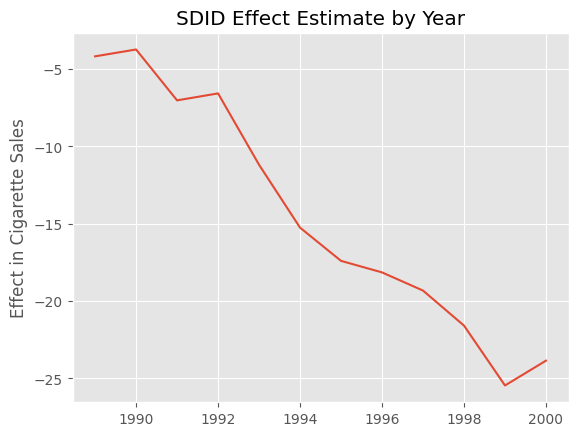

In [ ]:
plt.plot(effects);
plt.ylabel("Effect in Cigarette Sales")
plt.title("SDID Effect Estimate by Year");

As expected, the effect gets bigger as time passes. It starts small, but it gradually increases to what seems like a decrease in consumption of 25 cigarette packs per capita in 2020. 
 
Conveniently, running multiple SDID will also be important to deal with the staggered adoption case. With staggered addoption design, we have multiple treated units, which get the treatment at different time periods. For example, goin back to our very simple assignment matrix, with 3 units and 4 time periods, let's say unit 1 never get the treatment, unit 2 gets the treatment at period 4 and unit 3 gets the treatment at period 3. This would result in the following matrix
 
$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$
 
Notice that SDID can't handle that matrix, because we don't have a clear definition about what is a pre-treatment period (before time 4, in the case of the second unit or before period 3, in the case of the second unit) or what is a control unit (unit 2 could be a control for the treatment starting at period 3). The key in solving this is realizing we can delete columns (units) or rows (time periods) in that matrix in order to go back to the block assignment design.
 
For example, we can create two block matrices from the one above by first deleting the 3rd time period and then another one where we delete the 4th time period.
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$
 
 
The result is two block matrices, which means we can run SDID in both of them. The result will be two $ATT$ estimates, which we can then combine with a weighted average, where the weights are the proportion of treated time and periods in each block. In our example, the weight for $ATT_1$ would be $2/3$ and the weight for $ATT_2$ would be 1/3.
 
Alternatively, we could also have 2 block designs by removing columns, which would result in the following matrices
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1  \\
    0_2 & 0_2  \\
    0_3 & 0_3  \\
    0_4 & 1_4  \\
\end{bmatrix}
$$
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 \\
    0_2 & 0_2 \\
    0_3 & 1_3 \\
    0_4 & 1_4 \\
\end{bmatrix}
$$
 
where $D_1$ has units 1 and 2 and $D_2$ has units 1 and 4. 
 
Since we already saw how to estimate SDID for different time periods, let's look at this approach where we filter out units. Since we don't originally have a staggered adoption design in our Proposition 99 data, let's instead simulate one. We'll create 3 new Countrys from our data and pretend they pass a law similar to Proposition 99, but in the year 1993. Maybe they were impressed with the results in California and wanted to try in their Countrys too. Once they do, this law that they pass decreases cigarette consumption by 3% each year. We can visualize the average cigarette consumption for those  new Countrys to better understand what is going on. In dashed black, we have the year in which these Countrys pass this anti-tobacco law. 

In [ ]:
np.random.seed(1)
n = 3
tr_Country = (data
            .query(f"Country.isin({list(np.random.choice(data['Country'].unique(), n))})")
            .assign(**{
                "treated": True,
                "Country": lambda d: "new_" + d["Country"].astype(str),
                "after_treatment": lambda d: d["year"] > 1992
            })
            # effect of 3% / year
            .assign(**{"cigsale": lambda d: np.random.normal(d["cigsale"] - 
                                                             d["cigsale"]*(0.03*(d["year"] - 1992))*d["after_treatment"], 1)}))

new_data = pd.concat([data, tr_Country]).assign(**{"after_treatment": lambda d: np.where(d["treated"], d["after_treatment"], np.nan)})

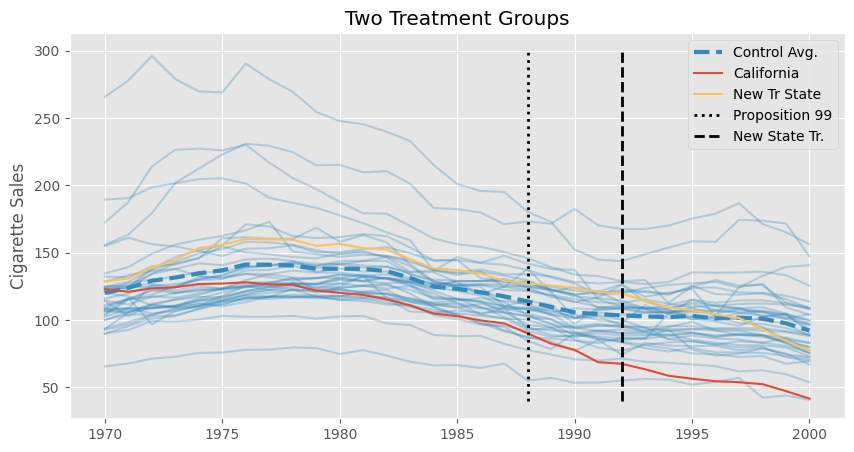

In [ ]:
new_dfs_piv = new_dfs.pivot("year", "Country", "cigsale")

new_tr_Countrys = list(filter(lambda c: str(c).startswith("new"), new_dfs_piv.columns))

plt.figure(figsize=(10,5))
plt.plot(new_dfs_piv.drop(columns=["california"]+new_tr_Countrys), color="C1", alpha=0.3)
plt.plot(new_dfs_piv.drop(columns=["california"]+new_tr_Countrys).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")

plt.plot(new_dfs_piv["california"], color="C0", label="California")
plt.plot(new_dfs_piv[new_tr_Countrys].mean(axis=1), color="C4", label="New Tr Country")

plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.vlines(x=1992, ymin=40, ymax=300, linestyle="dashed", lw=2, label="New Country Tr.", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Two Treatment Groups");

In [ ]:
new_dfs_piv

state,1,2,4,5,6,...,39,california,new_13,new_38,new_9
year,,,,,,,,,,,
1970,89.800003,100.300003,124.800003,120.000000,155.000000,...,132.199997,123.000000,154.954797,106.888520,124.271831
1971,95.400002,104.099998,125.500000,117.599998,161.100006,...,131.699997,121.000000,162.828754,105.324430,124.527030
1972,101.099998,103.900002,134.300003,110.800003,156.300003,...,140.000000,123.500000,179.387329,109.931632,127.465406
1973,102.900002,108.000000,137.899994,109.300003,154.699997,...,141.199997,124.400002,200.782684,111.019817,122.098463
1974,108.199997,109.699997,132.800003,112.400002,151.300003,...,145.800003,126.699997,212.634410,113.985578,133.644806
1975,111.699997,114.800003,131.000000,110.199997,147.600006,...,160.699997,127.099998,224.659802,112.103504,131.038796
1976,116.199997,119.099998,134.199997,113.400002,153.000000,...,161.500000,128.000000,231.642038,113.955888,134.719033
1977,117.099998,122.599998,132.000000,117.300003,153.300003,...,160.399994,126.400002,229.208158,116.695531,133.750630
1978,123.000000,127.300003,129.199997,117.500000,155.500000,...,160.300003,126.099998,223.812368,116.860034,138.162105


We finally have this staggered adoption dfs. Now, we need to figure out how to filter out some Countrys so we can break the problem into multiple block assignment cases. First, we can group Countrys by when they passed the law. The following code does exactly that.

In [ ]:
assignment_blocks = (new_dfs.query("treated & after_treatment")
                     .groupby("Country")["year"].min()
                     .reset_index()
                     .groupby("year")["Country"].apply(list).to_dict())

assignment_blocks

{1989: ['california'], 1993: ['new_13', 'new_38', 'new_9']}

As you can see, we have two groups of Countrys. One with only California, which was treated starting in 1989, and another with the three new Countrys we've created, which were all treated starting in 1993. Now, we need to run SDID for each of those groups. We can easily do that, but keeping just the control units plus one of those groups. There is a catch, though. The `after_treatment` column will have a different meaning, depending on which group we are looking at. If we are looking at the group containing only California, `after_treatment` should be `year >= 1989`; if we are looking at the group with the new Countrys, it should be `year >= 1993`. Fortunately, this is pretty easy to account for. All we need is to recreate the `after_treatment` in each iteration. 

In [ ]:
staggered_effects = {year: synthetic_diff_in_diff(new_data
                                                   .query(f"~treated|(Country.isin({Countrys}))")
                                                   .assign(**{"after_treatment": lambda d: d["year"] >= year}),
                                                  outcome_col="cigsale",
                                                  year_col="year",
                                                  Country_col="Country",
                                                  treat_col="treated",
                                                  post_col="after_treatment")
                     for year, Countrys in assignment_blocks.items()}

staggered_effects

{1989: -15.605398746342328, 1993: -17.24943592017881}

Not surprisingly, the $ATT$ estimate for the first group, the one with only California, is exactly the same as the one we've seen before. The other $ATT$ refers to the one we get with the new group of Countrys. We have to combine them into a single $ATT$. This can be done with the weighted average we've explained earlier. 
 
First, we calculate the number of treated entries (`after_treatment & treated`) in each block. Then, we combine the $ATT$s using those weights. 

In [ ]:
weights = {year: sum((new_data["year"] >= year) & (new_data["Country"].isin(Countrys)))
           for year, Countrys in assignment_blocks.items()}

att = sum([effect*weights[year]/sum(weights.values()) for year, effect in staggered_effects.items()])

print("weights: ", weights)
print("ATT: ", att)

weights:  {1989: 12, 1993: 24}
ATT:  -16.701423528899983


Here, we have a total of 36 treatment instances: the usual 12 post-treatment periods for California plus 8 treatment periods (1993-2000) for each of the three new treatment Countrys we've introduced. With that in mind, the weight for the first $ATT$ is $12/36$ and for the second $ATT$, $24/36$, which combines to the result above.
 
## Placebo Variance Estimation
 
This chapter is getting a bit too long, but there is one promise we haven't fulfilled yet. Remember how we said, in the very beginning, that SDID has better precision (lower error bars) when compared to Synthetic Controls? The reason is that the time and unit fixed effects in SDID captures a tone of the variation in the outcome, which in turn, reduces the variance of the estimator.
 
Of course I wouldn't ask you to take my word for it, so next, we'll show how to place a confidence interval around the SDID estimate. It turns out there are many solutions to this problem, but only one that fits the case for a single treated unit, which is the case we have here since only California was treated. The idea is to run a series of placebo tests, where we pretend a unit from the control pool is treated, when it actually isn't. Then, we use SDID to estimate the $ATT$ of this placebo test and store its result. We re-run this step multiple times, sampling a control unit each time. In the end, we will have an array of placebo $ATT$s. The variance of this array is the placebo variance of the SDID effect estimate, which we can use to construct a confidence interval.
 
$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$
 
$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$
 
In order to implement this, the first thing we need is a function which creates the placebo. This function will filter out the treated units, sample a single control unit and flip the `treated` column for that control unit from 0 to a 1.

In [ ]:
def make_random_placebo(data, Country_col, treat_col):
    control = dfs.query(f"~{treat_col}")
    Countrys = control[Country_col].unique()
    placebo_Country = np.random.choice(Countrys)
    return control.assign(**{treat_col: control[Country_col] == placebo_Country})

In [ ]:
np.random.seed(1)
placebo_data = make_random_placebo(data, Country_col="Country", treat_col="treated")

placebo_dfs.query("treated").tail()

,state,year,cigsale,treated,after_treatment
1204,39,1996,110.300003,True,True
1205,39,1997,108.800003,True,True
1206,39,1998,102.900002,True,True
1207,39,1999,104.800003,True,True
1208,39,2000,90.500000,True,True


In the example above, we've sampled Country 39 and we are now pretending that it was treated. Notice how the `treated` column was flipped to `True`.
 
The next thing we need is to compute the SDID estimate with this placebo data and repeat that a bunch of times. The next function does that. It runs the `synthetic_diff_in_diff` function to get the SDID estimate, but instead of passing the usual data, we pass the result of calling `make_random_placebo`. We do that multiple times to get an array of SDID estimates and, finally, compute the square root of the variance of this array, which is just the standard deviation.

In [ ]:
from joblib import Parallel, delayed # for parallel processing


def estimate_se(data, outcome_col, year_col, Country_col, treat_col, post_col, bootstrap_rounds=400, seed=0, njobs=4):
    np.random.seed(seed=seed)
    
    sdid_fn = partial(synthetic_diff_in_diff,
                      outcome_col=outcome_col,
                      year_col=year_col,
                      Country_col=Country_col,
                      treat_col=treat_col,
                      post_col=post_col)
    
    effects = Parallel(n_jobs=njobs)(delayed(sdid_fn)(make_random_placebo(data, Country_col=Country_col, treat_col=treat_col))
                                     for _ in range(bootstrap_rounds))
    
    return np.std(effects, axis=0)


In [ ]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                Country_col="Country",
                                treat_col="treated",
                                post_col="after_treatment")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 Country_col="Country",
                 treat_col="treated",
                 post_col="after_treatment")

The standard deviation can then be used to construct confidence intervals much like we described in the formula above.

In [ ]:
print(f"Effect: {effect}")
print(f"Standard Error: {se}")
print(f"90% CI: ({effect-1.65*se}, {effect+1.65*se})")

Effect: -15.605398746342328
Standard Error: 9.912089792199428
90% CI: (-31.960346903471383, 0.7495494107867273)


Notice that the $ATT$ is not significant in this case, but what's more interesting here is to compare the standard error of the SDID estimate with the one we get from traditional Synthetic Control.

In [ ]:
def synthetic_control(data, outcome_col, year_col, Country_col, treat_col, post_col):
    
    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(year_col, Country_col, outcome_col)
                     .values)
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control@w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    sc = (data
          .query(f"~{treat_col}")
          .pivot(year_col, Country_col, outcome_col)
          .values) @ w.value
    
    y1 = dfs.query(f"{treat_col}").query(f"{post_col}")[outcome_col]
    att = np.mean(y1 - sc[-len(y1):])
    
    return att


def estimate_se_sc(data, outcome_col, year_col, Country_col, treat_col, post_col, bootstrap_rounds=400, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_control(make_random_placebo(data, Country_col=Country_col, treat_col=treat_col), 
                                 outcome_col=outcome_col,
                                 year_col=year_col,
                                 Country_col=Country_col,
                                 treat_col=treat_col,
                                 post_col=post_col)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


effect_sc = synthetic_control(data,
                              outcome_col="cigsale",
                              year_col="year",
                              Country_col="Country",
                              treat_col="treated",
                              post_col="after_treatment")


se_sc = estimate_se_sc(data,
                       outcome_col="cigsale",
                       year_col="year",
                       Country_col="Country",
                       treat_col="treated",
                       post_col="after_treatment")

In [ ]:
print(f"Effect: {effect_sc}")
print(f"Standard Error: {se_sc}")
print(f"90% CI: ({effect_sc-1.65*se_sc}, {effect_sc+1.65*se_sc})")

Effect: -19.513629763998537
Standard Error: 11.241934948975807
90% CI: (-38.06282242980862, -0.9644370981884585)


Notice how the error for synthetic control is higher than for SDID. Again, that is because SDID captures a lot of the variance in the outcome via its time and unit fixed effect. With this, we fulfill that promise we've made earlier. But, before we close, it is worth mentioning that we can also use the same procedure to estimate the variance to make a confidence interval around the effect we've estimated for each post-treatment time period. All we need to do is run the code above once for each time period. Just keep in mind that this might take some time to run, even with the parallelization we've implemented.

In [ ]:
standard_errors = {year: estimate_se(dfs.query(f"~after_treatment|(year=={year})"), 
                                     outcome_col="cigsale",
                                     year_col="year",
                                     Country_col="Country",
                                     treat_col="treated",
                                     post_col="after_treatment")
                   for year in range(1989, 2001)}

standard_errors = pd.Series(standard_errors)

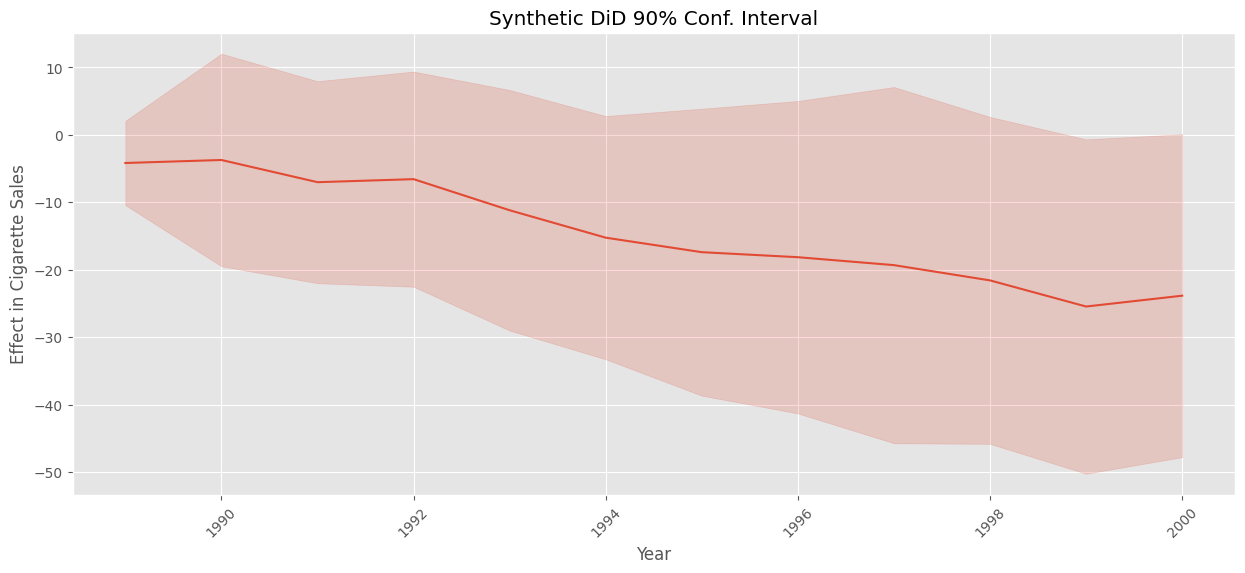

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(effects, color="C0")
plt.fill_between(effects.index, effects-1.65*standard_errors, effects+1.65*standard_errors, alpha=0.2,  color="C0")

plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year")
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45);

## Key Concepts

Synthetic-Diff-in-Diff (SDID) draws inspiration from both Diff-in-Diff and Synthetic Control, which brings advantages from both models.  Like SC, SDID still works with multiple periods when pre-treatment trends are not parallel. However, unlike SC, SDID estimate unit weights to build a control unit which is only parallel to the treated group (it doesn't have to match its level). From DID, SDID leverages time and unit fixed effect, which helps to explain a way a lot of the variance in the outcome, which in turn reduces the variance of the SDID estimator. Synthetic-Diff-in-Diff also introduces some new ideas of its own. First, there is an additional $L2$ penalty in the optimization of the unit weights which makes them more spread out across control units. Second, SDID allows for an intercept (and hence, extrapolation) when building sutch weights. Third, SDID introduces the use of time weights, which are not present in neither DID nor SC. For this reason, I would't say SDID is just merging SC and SDID. It is rather building something new, inspired by these two approaches. I also wouldn't say that SDID is better or worse than traditional Synthetic Control. Each of them have different properties that might be appropriate or not, depending on the situation. For example, you might find yourself in a situation where allowing the extrapolations from SDID is dangerous. In which case, SC might be a good alternative.  


## References 
 
This chapter is essentially an explainer to the *Synthetic Difference in Differences* (2019) article, by Dmitry Arkhangelsky, Susan Athey, David A. Hirshberg, Guido W. Imbens and Stefan Wager. Additionally, I would love to recognize Masa Asami for his python implementation of SDID, pysynthdid. His code helped me make sure I didn't have any bugs in mine, which was extremely helpful. 
 
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).